In [70]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import shap

In [71]:
df_train = pd.read_csv('data/train_data.csv')
df_test = pd.read_csv('data/test_data.csv')
# 拔掉UUID, 客戶編號, 以及兩個分類器的結果
Y_train = df_train['Attrition_Flag']
X_train = df_train.drop(columns=['Attrition_Flag', "CLIENTNUM"])

Y_test = df_test['Attrition_Flag']
X_test = df_test.drop(columns=['Attrition_Flag', "CLIENTNUM"])


In [72]:
print("原始特徵維度：", X_train.shape)

原始特徵維度： (6864, 19)


In [73]:
categorical_cols = X_train.select_dtypes(include='object').columns
print(f"需要進行 One-Hot Encoding 的類別型欄位: {list(categorical_cols)}")

需要進行 One-Hot Encoding 的類別型欄位: ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


In [74]:
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
print(f"One-Hot Encoding 後 Train 的特徵維度: {X_train_encoded.shape}")
print(f"One-Hot Encoding 後 Test 的特徵維度: {X_test_encoded.shape}")


One-Hot Encoding 後 Train 的特徵維度: (6864, 32)
One-Hot Encoding 後 Test 的特徵維度: (1472, 32)


In [75]:
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.fit_transform(Y_test)
print(f"\n目標變數編碼對應關係: {label_encoder.classes_} -> {label_encoder.transform(label_encoder.classes_)}")


目標變數編碼對應關係: ['Attrited Customer' 'Existing Customer'] -> [0 1]


In [76]:
print(f"\n訓練集目標變數分佈:")
print(pd.Series(Y_train).value_counts(normalize=True))  
print(f"\n測試集目標變數分佈:")
print(pd.Series(Y_test).value_counts(normalize=True))   



訓練集目標變數分佈:
Attrition_Flag
Existing Customer    0.839307
Attrited Customer    0.160693
Name: proportion, dtype: float64

測試集目標變數分佈:
Attrition_Flag
Existing Customer    0.838995
Attrited Customer    0.161005
Name: proportion, dtype: float64


In [77]:
xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=len(Y_train_encoded[Y_train_encoded == 0]) / len(Y_train_encoded[Y_train_encoded == 1])  # 處理類別不平衡
)
xgb_model.fit(X_train_encoded, Y_train_encoded)

/opt/anaconda3/envs/lecture/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [78]:
y_pred = xgb_model.predict(X_test_encoded)
y_pred_proba = xgb_model.predict_proba(X_test_encoded)[:, 1] # 預測為正例 (流失) 的機率

In [79]:
print("混淆矩陣：")
print(confusion_matrix(Y_test_encoded, y_pred))

混淆矩陣：
[[ 217   20]
 [  26 1209]]


In [80]:
print("\n分類報告 (Classification Report):")
print(classification_report(Y_test_encoded, y_pred, target_names=label_encoder.classes_))


分類報告 (Classification Report):
                   precision    recall  f1-score   support

Attrited Customer       0.89      0.92      0.90       237
Existing Customer       0.98      0.98      0.98      1235

         accuracy                           0.97      1472
        macro avg       0.94      0.95      0.94      1472
     weighted avg       0.97      0.97      0.97      1472



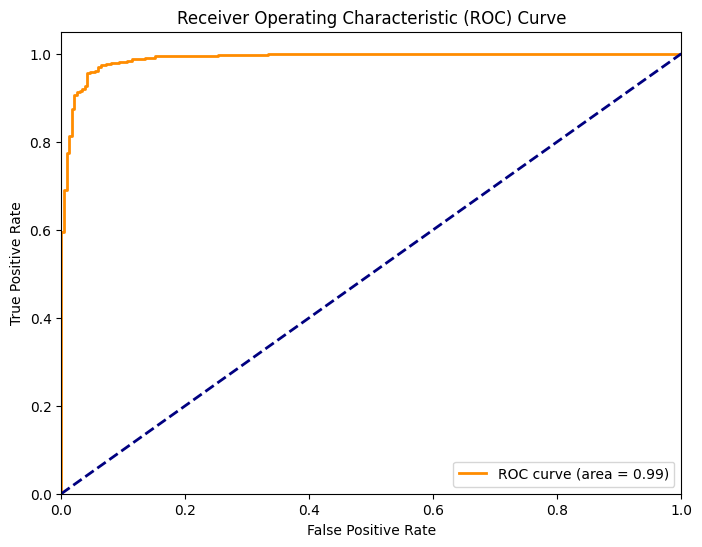

In [81]:
fpr, tpr, thresholds_roc = roc_curve(Y_test_encoded, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

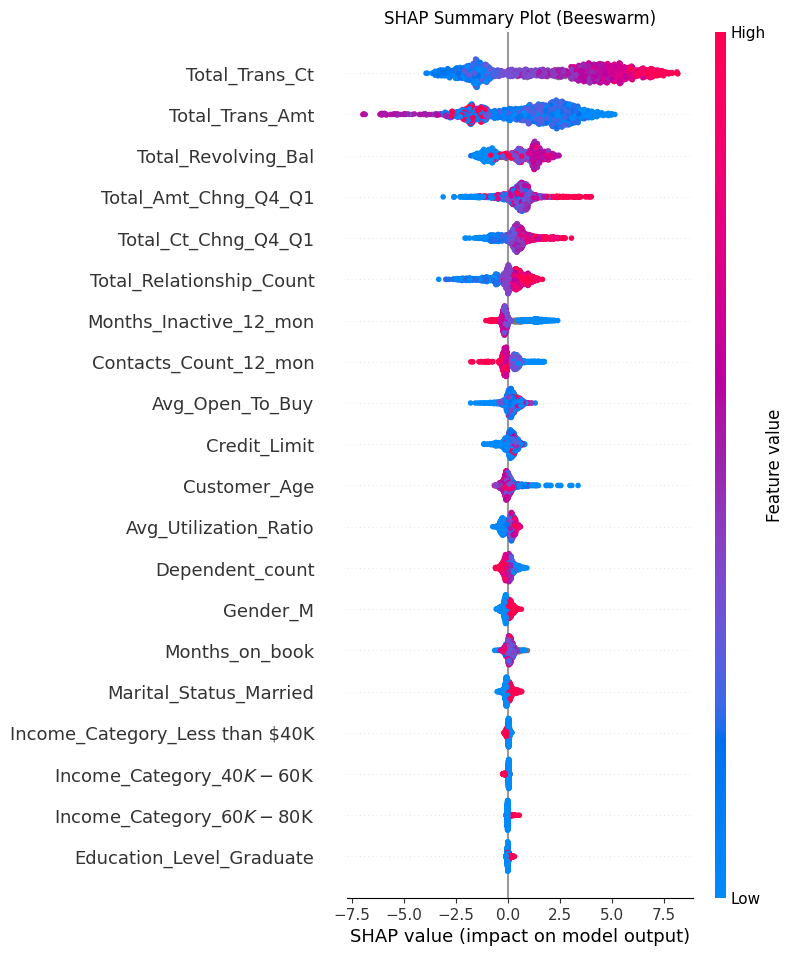

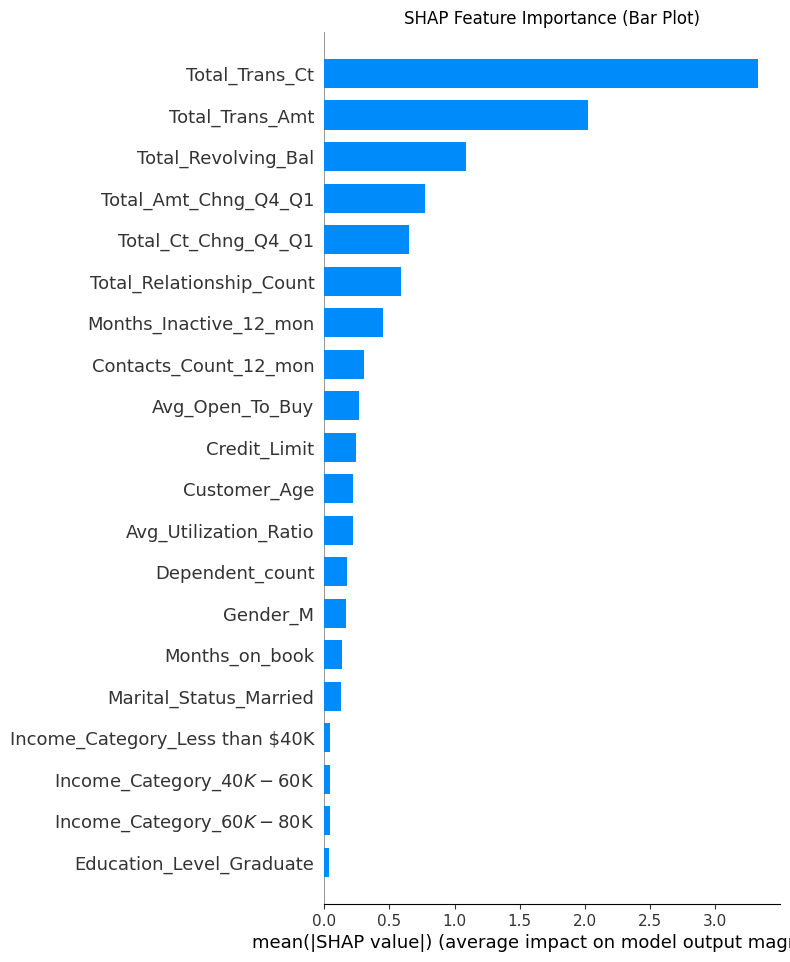

In [82]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_encoded)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_encoded, show=False)
plt.title("SHAP Summary Plot (Beeswarm)")
plt.show()

plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test_encoded, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Bar Plot)")
plt.show()

In [83]:
import numpy as np

fp_indices = np.where((y_pred == 1) & (Y_test_encoded == 0))[0]
print(f"找到 {len(fp_indices)} 個偽陽性案例 (預測留存，實際流失)")
# 為了比較，我們也提取 TN (真陰性) 案例: 真實為 Attrited (0), 預測為 Attrited (0)
tn_indices = np.where((Y_test_encoded == 0) & (y_pred == 0))[0]
print(f"總共找到 {len(tn_indices)} 個真陰性 (TN) 案例（用於比較）。\n")

找到 20 個偽陽性案例 (預測留存，實際流失)
總共找到 217 個真陰性 (TN) 案例（用於比較）。




--- 分析偽陽性案例 (索引: 463) ---
真實標籤: 0 (Attrited), 預測標籤: 1 (Existing)


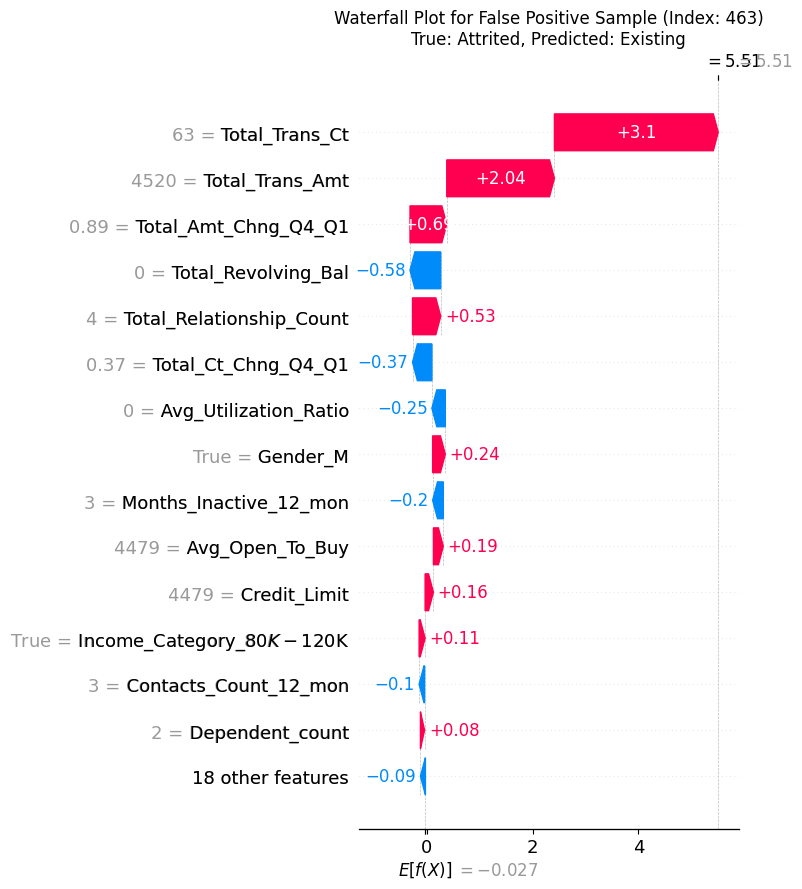

In [84]:
# 分析一個偽陽性案例 (例如第一個偽陽性案例)
if len(fp_indices) > 0:
    idx_to_analyze_fp = fp_indices[0]
    print(f"\n--- 分析偽陽性案例 (索引: {idx_to_analyze_fp}) ---")
    print(f"真實標籤: {Y_test_encoded[idx_to_analyze_fp]} (Attrited), 預測標籤: {y_pred[idx_to_analyze_fp]} (Existing)")

    shap_explanation_fp = shap.Explanation(
        values=shap_values[idx_to_analyze_fp,:],
        base_values=explainer.expected_value, # 通常是 explainer.expected_value
        data=X_test_encoded.iloc[idx_to_analyze_fp,:].values, # Waterfall 需要 .values
        feature_names=X_test_encoded.columns.tolist()
    )
    plt.figure()
    shap.plots.waterfall(shap_explanation_fp, max_display=15, show=False)
    plt.title(f"Waterfall Plot for False Positive Sample (Index: {idx_to_analyze_fp})\nTrue: Attrited, Predicted: Existing")
    plt.tight_layout()
    plt.show()


--- FP 案例中，各特徵平均 SHAP 值 (推向 Existing 的貢獻) ---
正值越大，代表該特徵平均而言越是將這些錯誤案例推向「Existing」
                           feature  mean_shap_value
10                 Total_Trans_Amt         1.142086
7              Total_Revolving_Bal         0.550920
12             Total_Ct_Chng_Q4_Q1         0.458838
4           Months_Inactive_12_mon         0.214500
8                  Avg_Open_To_Buy         0.208359
3         Total_Relationship_Count         0.156638
2                   Months_on_book         0.115162
14                        Gender_M         0.083805
9             Total_Amt_Chng_Q4_Q1         0.072453
1                  Dependent_count         0.061639
6                     Credit_Limit         0.050651
27  Income_Category_Less than $40K         0.041538
26    Income_Category_$80K - $120K         0.034382
16        Education_Level_Graduate         0.020628
5            Contacts_Count_12_mon         0.020241

--- FP 案例的 SHAP 特徵影響力 (Bar Plot) ---


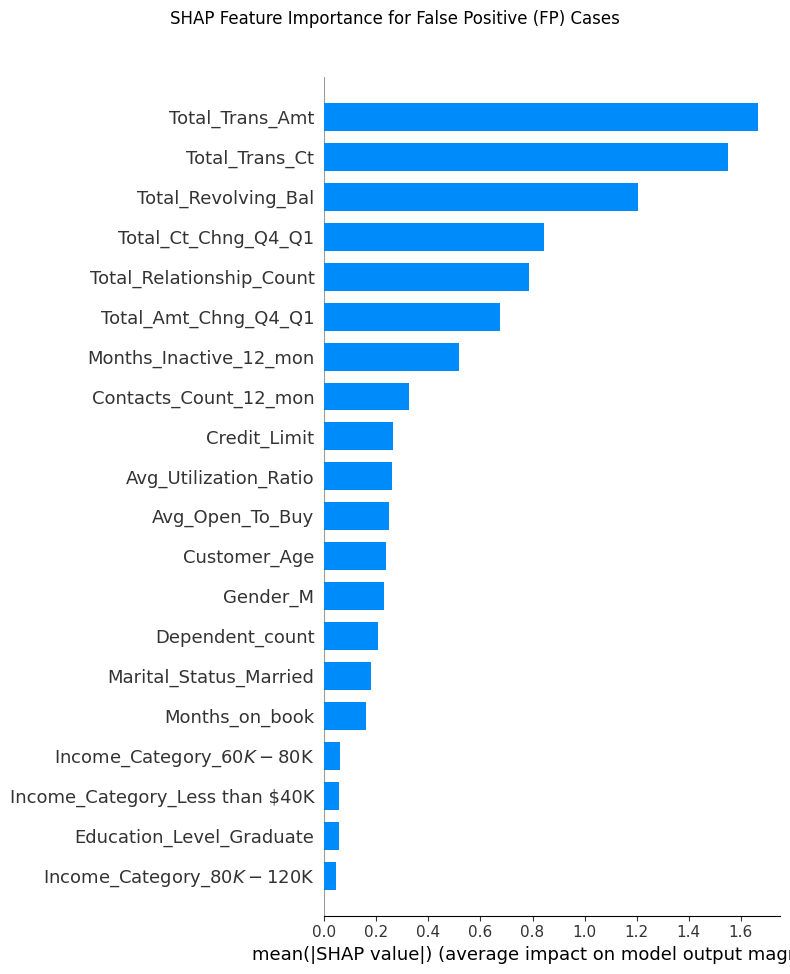

In [85]:
if len(fp_indices) > 0:
    # 提取 FP 案例的特徵數據、SHAP 值和真實標籤
    X_fp = X_test_encoded.iloc[fp_indices]
    shap_values_fp = shap_values[fp_indices, :]
    Y_fp_true = Y_test_encoded[fp_indices] # 這些都應該是 0



    # ---------------------------------------------------------------------------
    # 3. FP 案例的總體 SHAP 特徵重要性 (平均 SHAP 值)
    #    這顯示平均而言，哪些特徵將 FP 案例的預測推向了「錯誤的」Existing (正 SHAP 值)
    # ---------------------------------------------------------------------------
    if shap_values_fp.shape[0] > 0: # 確保有 FP 案例
        # 計算 FP 案例中每個特徵的平均 SHAP 值
        mean_shap_values_fp = np.mean(shap_values_fp, axis=0)
        
        # 創建一個包含特徵名稱和對應平均 SHAP 值的 DataFrame，並排序
        df_mean_shap_fp = pd.DataFrame({
            'feature': X_test_encoded.columns,
            'mean_shap_value': mean_shap_values_fp
        }).sort_values(by='mean_shap_value', ascending=False)

        print("\n--- FP 案例中，各特徵平均 SHAP 值 (推向 Existing 的貢獻) ---")
        print("正值越大，代表該特徵平均而言越是將這些錯誤案例推向「Existing」")
        print(df_mean_shap_fp.head(15)) # 顯示貢獻最大的前15個

        print("\n--- FP 案例的 SHAP 特徵影響力 (Bar Plot) ---")
        plt.figure(figsize=(10,8))
        shap.summary_plot(shap_values_fp, X_fp, plot_type="bar", show=False, max_display=20)
        # 獲取當前 Figure，然後修改其標題 (summary_plot 本身不直接接受 title)
        fig = plt.gcf()
        fig.suptitle("SHAP Feature Importance for False Positive (FP) Cases", y=1.02) # y調整標題位置
        plt.tight_layout() # 自動調整子圖參數以給定一個緊湊的佈局
        plt.show()




--- TN 案例中，各特徵平均 SHAP 值 (推向 Attrited 的貢獻) ---
負值越大，代表該特徵平均而言越是將這些正確案例推向「Attrited」
                        feature  mean_shap_value
11               Total_Trans_Ct        -1.782232
10              Total_Trans_Amt        -1.651926
3      Total_Relationship_Count        -0.585973
7           Total_Revolving_Bal        -0.565327
12          Total_Ct_Chng_Q4_Q1        -0.254301
9          Total_Amt_Chng_Q4_Q1        -0.142414
4        Months_Inactive_12_mon        -0.136452
13        Avg_Utilization_Ratio        -0.135590
14                     Gender_M        -0.106916
5         Contacts_Count_12_mon        -0.096725
0                  Customer_Age        -0.094763
6                  Credit_Limit        -0.058627
21       Marital_Status_Married        -0.018001
25  Income_Category_$60K - $80K        -0.015939
15    Education_Level_Doctorate        -0.002670

--- TN 案例的 SHAP 特徵影響力 (Bar Plot) ---


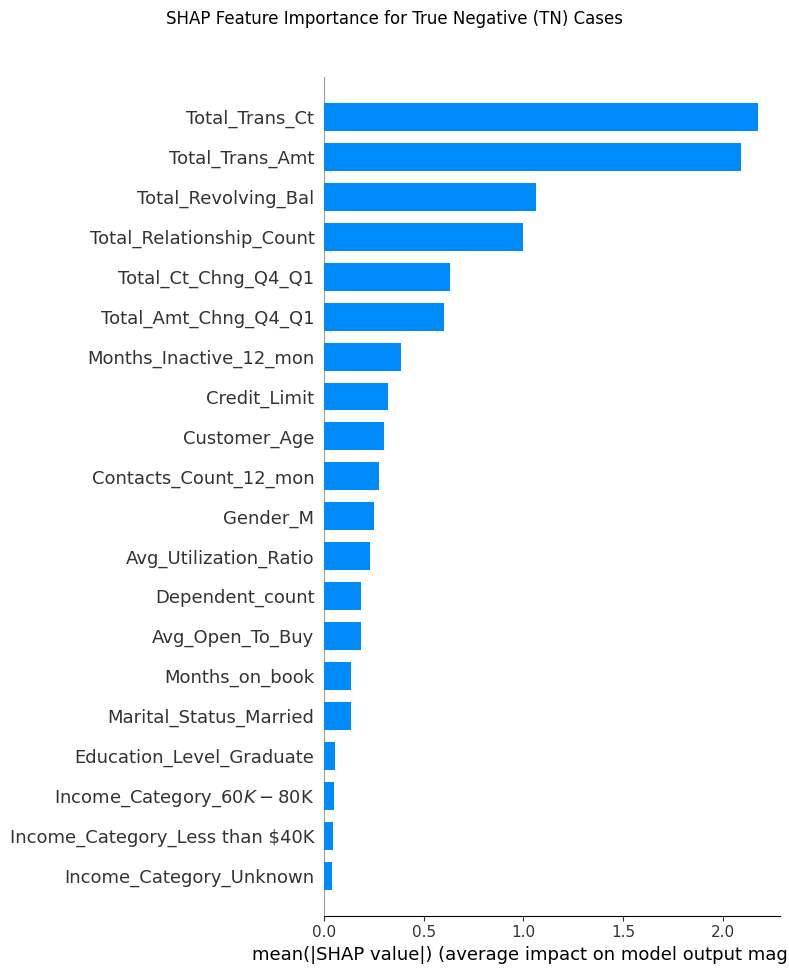

In [86]:
if len(tn_indices) > 0:
    shap_values_tn = shap_values[tn_indices, :]
    X_tn = X_test_encoded.iloc[tn_indices] # 確保 X_tn 也已提取

    # 計算 TN 案例中每個特徵的平均 SHAP 值
    mean_shap_values_tn = np.mean(shap_values_tn, axis=0)
    
    # 創建一個包含特徵名稱和對應平均 SHAP 值的 DataFrame，並排序
    # 這次我們可能對「負值最大」（最強烈推向 Attrited）的特徵感興趣
    df_mean_shap_tn = pd.DataFrame({
        'feature': X_test_encoded.columns,
        'mean_shap_value': mean_shap_values_tn
    }).sort_values(by='mean_shap_value', ascending=True) # ascending=True 使負值最大的排前面

    print("\n--- TN 案例中，各特徵平均 SHAP 值 (推向 Attrited 的貢獻) ---")
    print("負值越大，代表該特徵平均而言越是將這些正確案例推向「Attrited」")
    print(df_mean_shap_tn.head(15)) # 顯示最強烈推向 Attrited 的前15個特徵

    print("\n--- TN 案例的 SHAP 特徵影響力 (Bar Plot) ---")
    plt.figure(figsize=(10,8))
    shap.summary_plot(shap_values_tn, X_tn, plot_type="bar", show=False, max_display=20)
    fig = plt.gcf()
    fig.suptitle("SHAP Feature Importance for True Negative (TN) Cases", y=1.02)
    plt.tight_layout()
    plt.show()
    
else:
    print("在測試集中沒有找到任何真陰性 (TN) 案例可供分析。")

In [87]:
fp_probabilities = y_pred_proba[fp_indices]

# 創建一個包含 FP 索引和對應機率的 DataFrame 以便排序
df_fp_confidence = pd.DataFrame({
    'fp_index': fp_indices,
    'probability_existing': fp_probabilities
})

# 按機率降序排序
df_fp_confidence_sorted = df_fp_confidence.sort_values(by='probability_existing', ascending=False)
print(f"--- 分析模型「錯得最自信」的  FP 案例 ---")
print(df_fp_confidence_sorted)
print("-" * 50)

--- 分析模型「錯得最自信」的  FP 案例 ---
    fp_index  probability_existing
17      1458              0.999086
5        868              0.998228
0        463              0.995972
9       1053              0.992861
7        999              0.978848
14      1353              0.957520
13      1347              0.951778
4        803              0.949786
12      1228              0.938445
10      1079              0.925916
19      1471              0.785040
11      1149              0.772980
15      1430              0.756729
8       1023              0.745842
18      1463              0.632757
16      1440              0.611579
6        897              0.602165
2        581              0.563351
3        630              0.536903
1        486              0.522108
--------------------------------------------------


In [88]:
# 選取 Top N 案例進行分析 (例如 Top 3 或 Top 5)
# N_top_fps = min(20, len(df_fp_confidence_sorted)) # 最多看5個，或實際FP數量

N_top_fps = 34

top_n_fp_cases = df_fp_confidence_sorted.head(N_top_fps)

--- 分析模型「錯得最自信」的 Top 34 個 FP 案例 ---
    fp_index  probability_existing
17      1458              0.999086
5        868              0.998228
0        463              0.995972
9       1053              0.992861
7        999              0.978848
14      1353              0.957520
13      1347              0.951778
4        803              0.949786
12      1228              0.938445
10      1079              0.925916
19      1471              0.785040
11      1149              0.772980
15      1430              0.756729
8       1023              0.745842
18      1463              0.632757
16      1440              0.611579
6        897              0.602165
2        581              0.563351
3        630              0.536903
1        486              0.522108
--------------------------------------------------

正在分析 Top 1 FP 案例 (原始索引: 1458)
模型預測為 'Existing' 的機率: 0.9991
真實標籤: Attrited (0), 預測標籤: Existing (1)


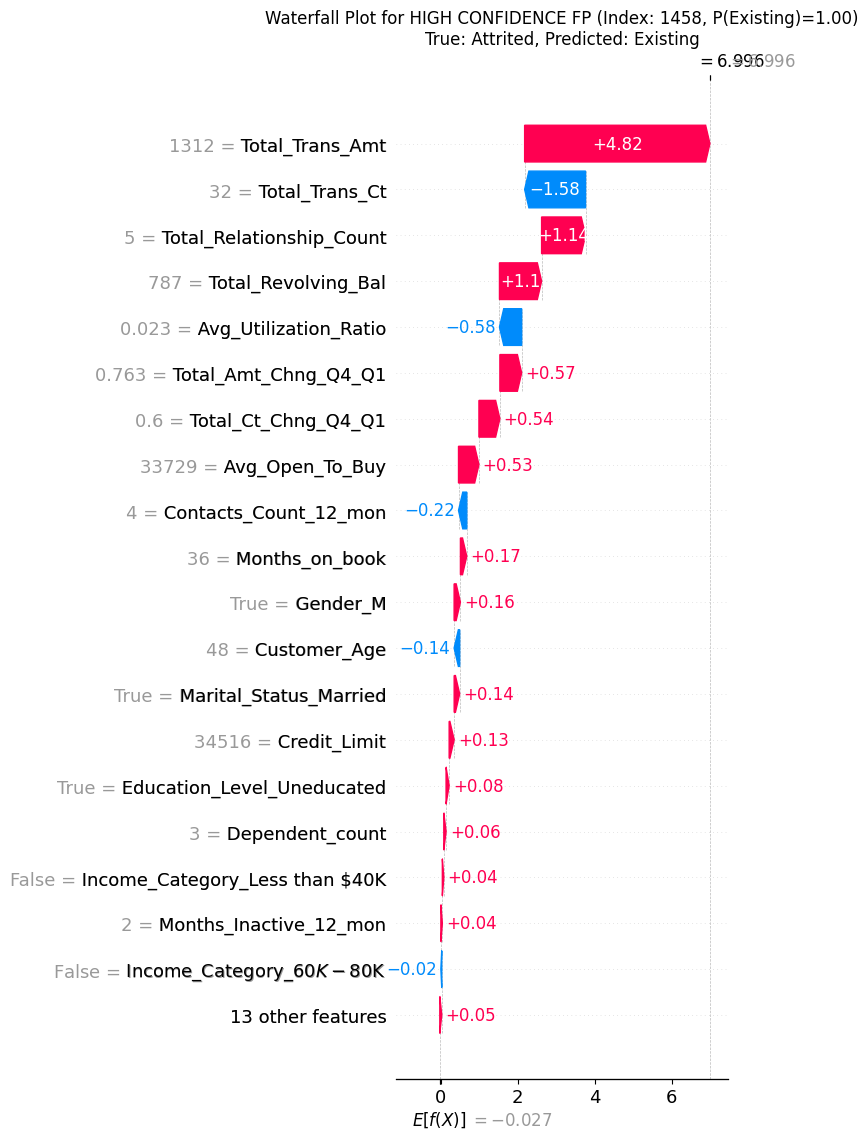


正在分析 Top 2 FP 案例 (原始索引: 868)
模型預測為 'Existing' 的機率: 0.9982
真實標籤: Attrited (0), 預測標籤: Existing (1)


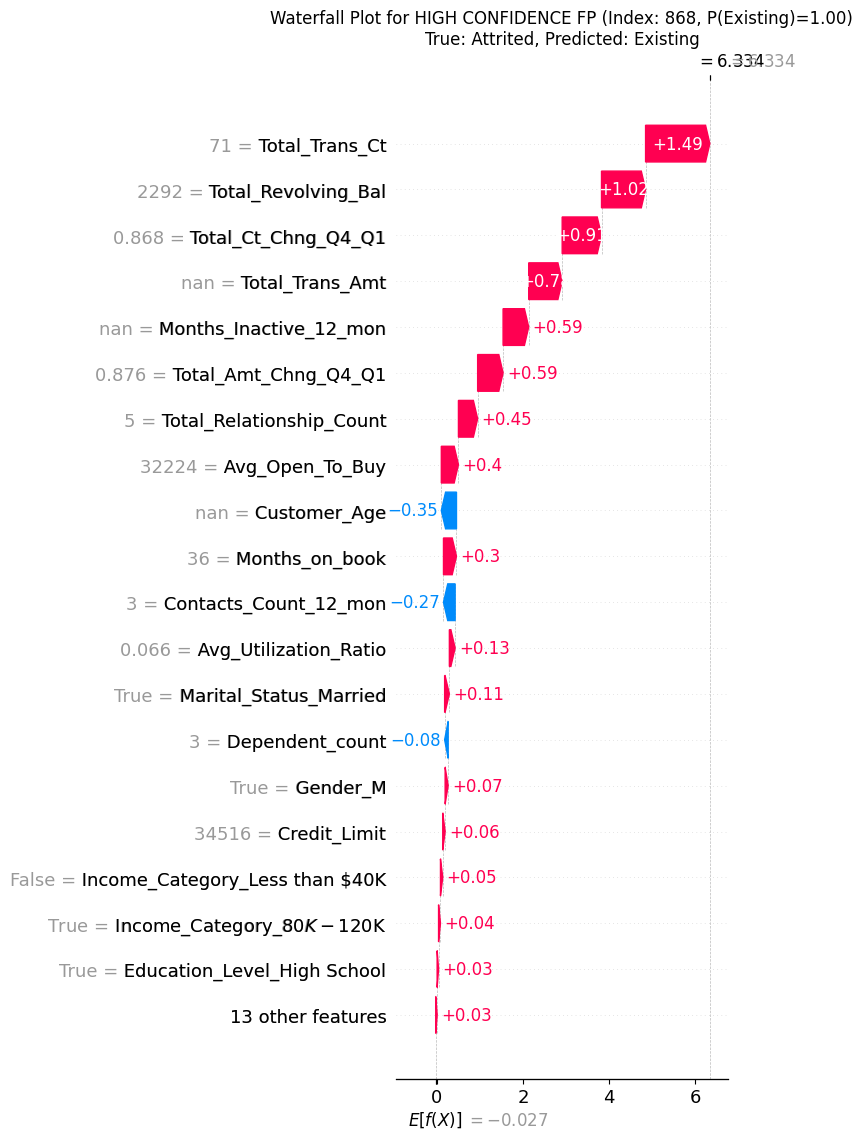


正在分析 Top 3 FP 案例 (原始索引: 463)
模型預測為 'Existing' 的機率: 0.9960
真實標籤: Attrited (0), 預測標籤: Existing (1)


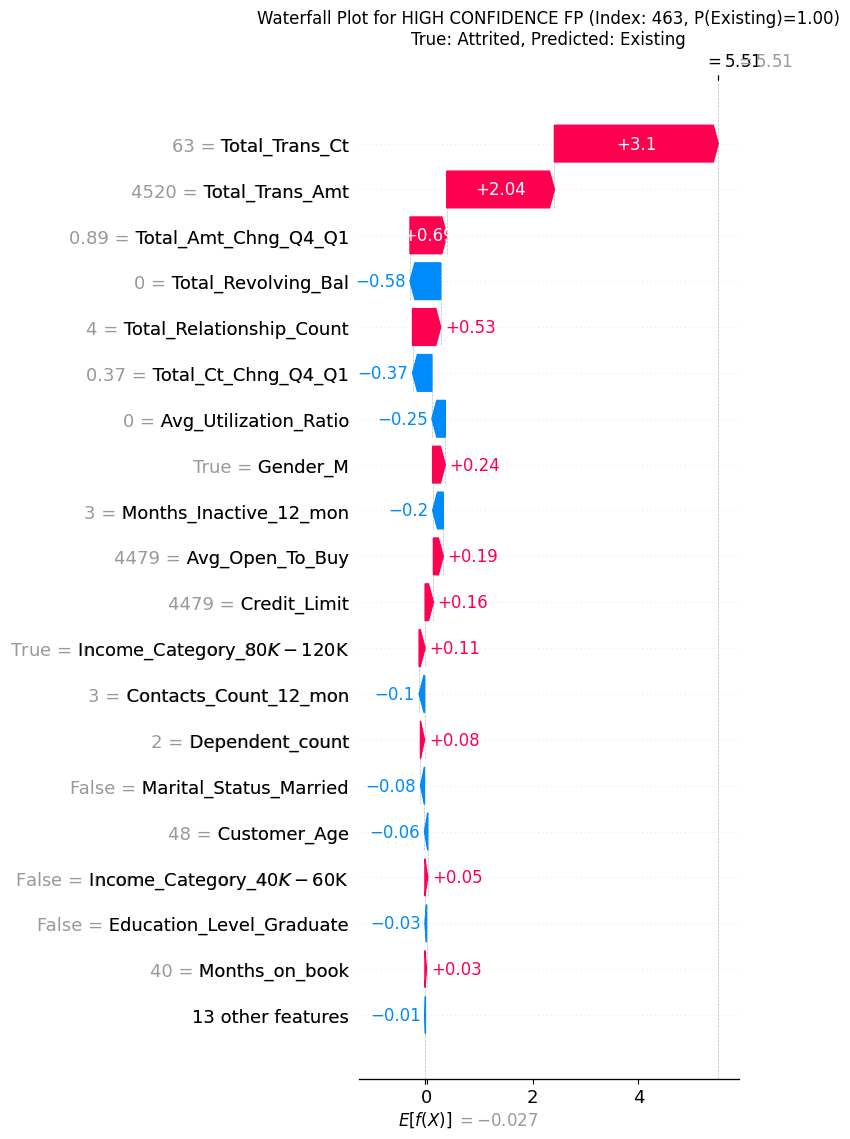


正在分析 Top 4 FP 案例 (原始索引: 1053)
模型預測為 'Existing' 的機率: 0.9929
真實標籤: Attrited (0), 預測標籤: Existing (1)


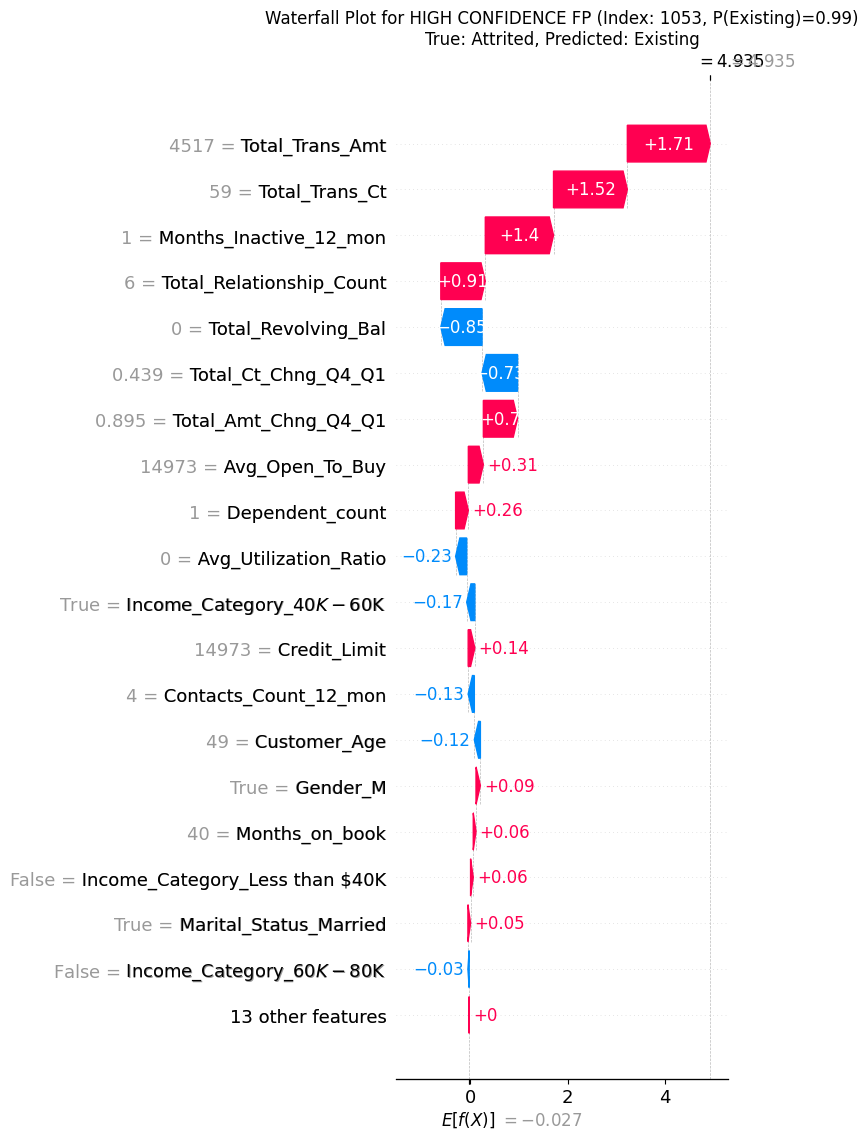


正在分析 Top 5 FP 案例 (原始索引: 999)
模型預測為 'Existing' 的機率: 0.9788
真實標籤: Attrited (0), 預測標籤: Existing (1)


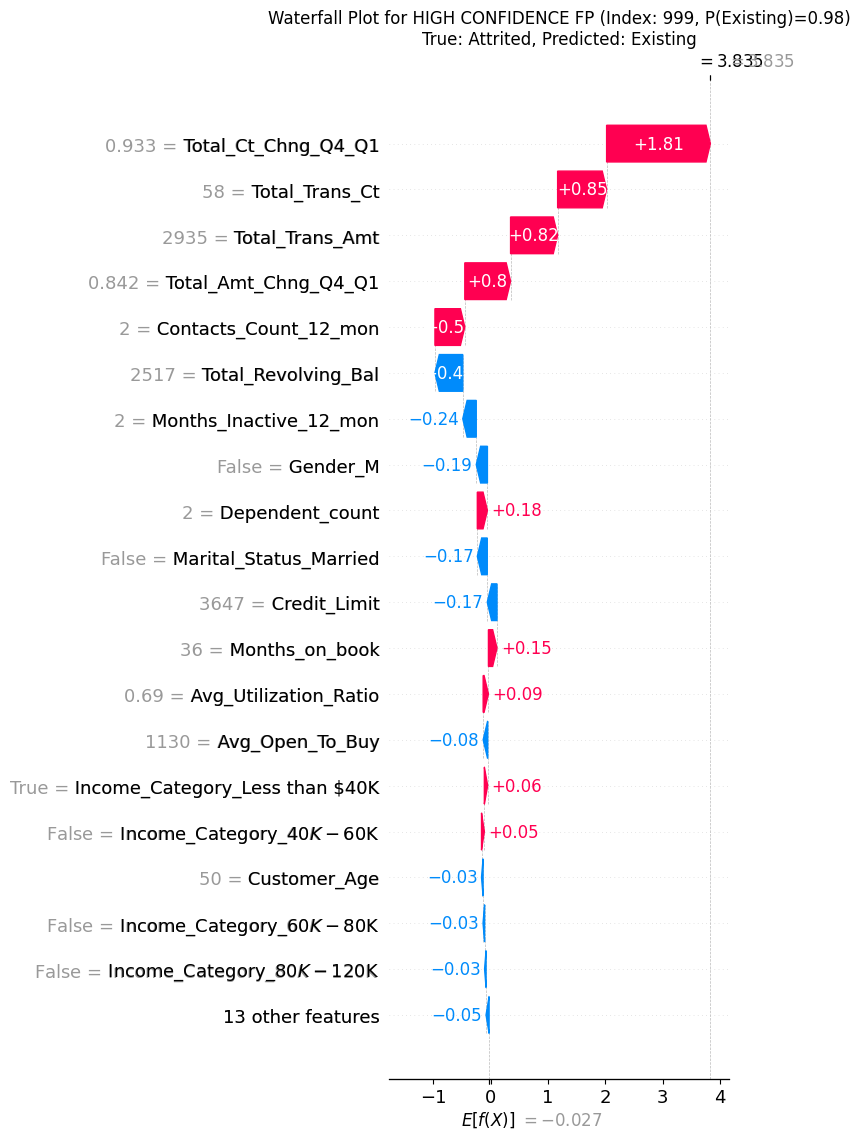


正在分析 Top 6 FP 案例 (原始索引: 1353)
模型預測為 'Existing' 的機率: 0.9575
真實標籤: Attrited (0), 預測標籤: Existing (1)


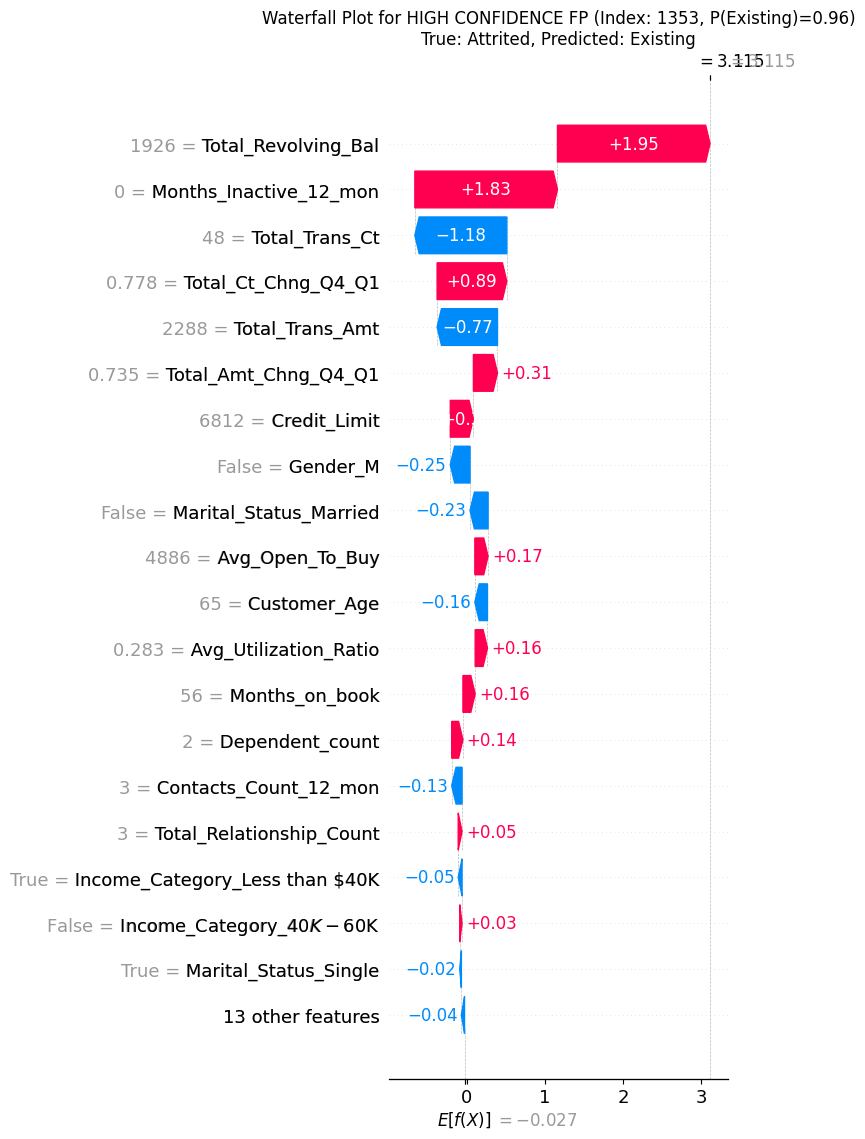


正在分析 Top 7 FP 案例 (原始索引: 1347)
模型預測為 'Existing' 的機率: 0.9518
真實標籤: Attrited (0), 預測標籤: Existing (1)


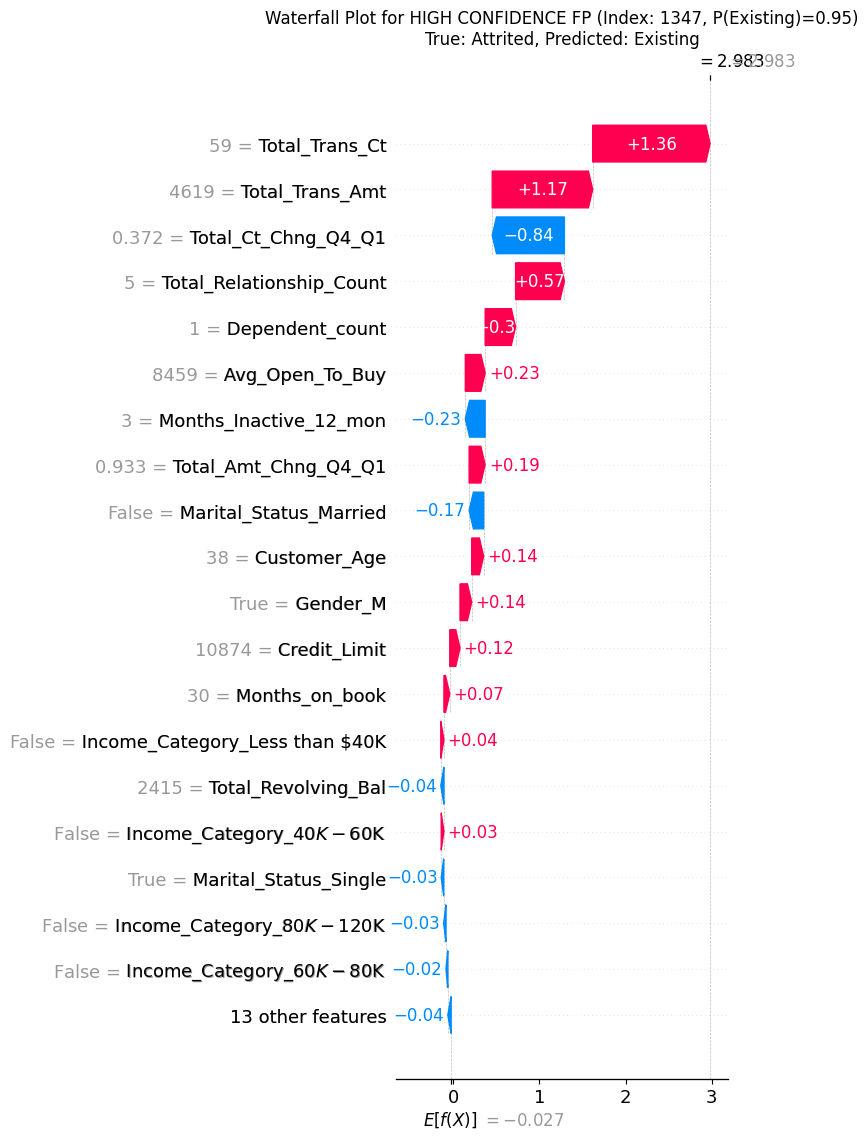


正在分析 Top 8 FP 案例 (原始索引: 803)
模型預測為 'Existing' 的機率: 0.9498
真實標籤: Attrited (0), 預測標籤: Existing (1)


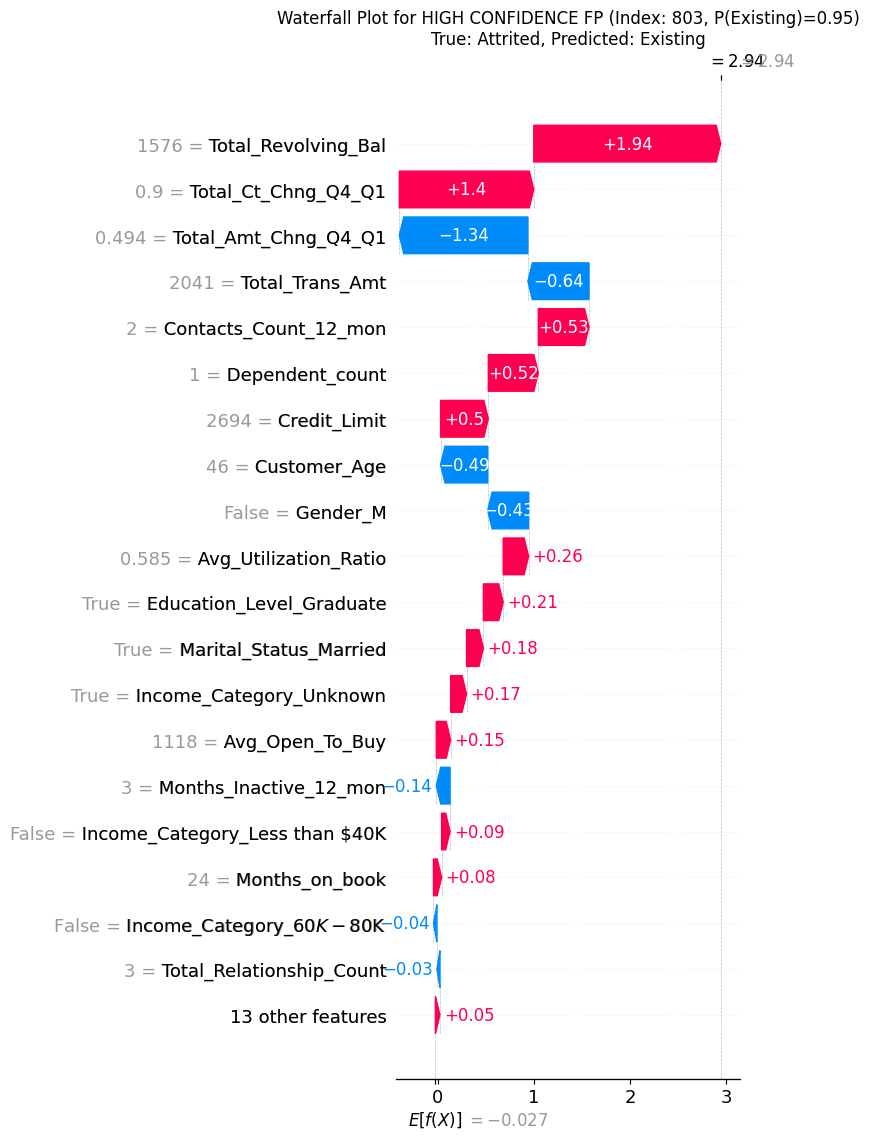


正在分析 Top 9 FP 案例 (原始索引: 1228)
模型預測為 'Existing' 的機率: 0.9384
真實標籤: Attrited (0), 預測標籤: Existing (1)


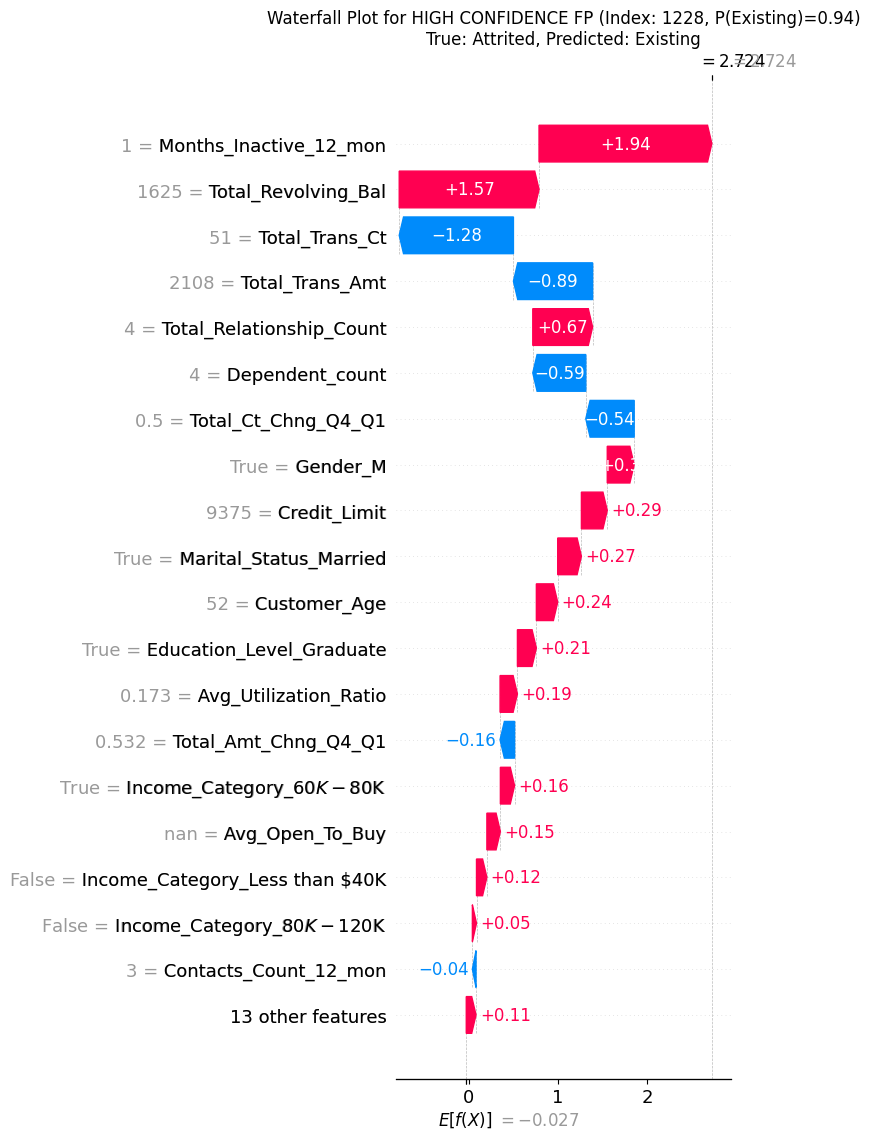


正在分析 Top 10 FP 案例 (原始索引: 1079)
模型預測為 'Existing' 的機率: 0.9259
真實標籤: Attrited (0), 預測標籤: Existing (1)


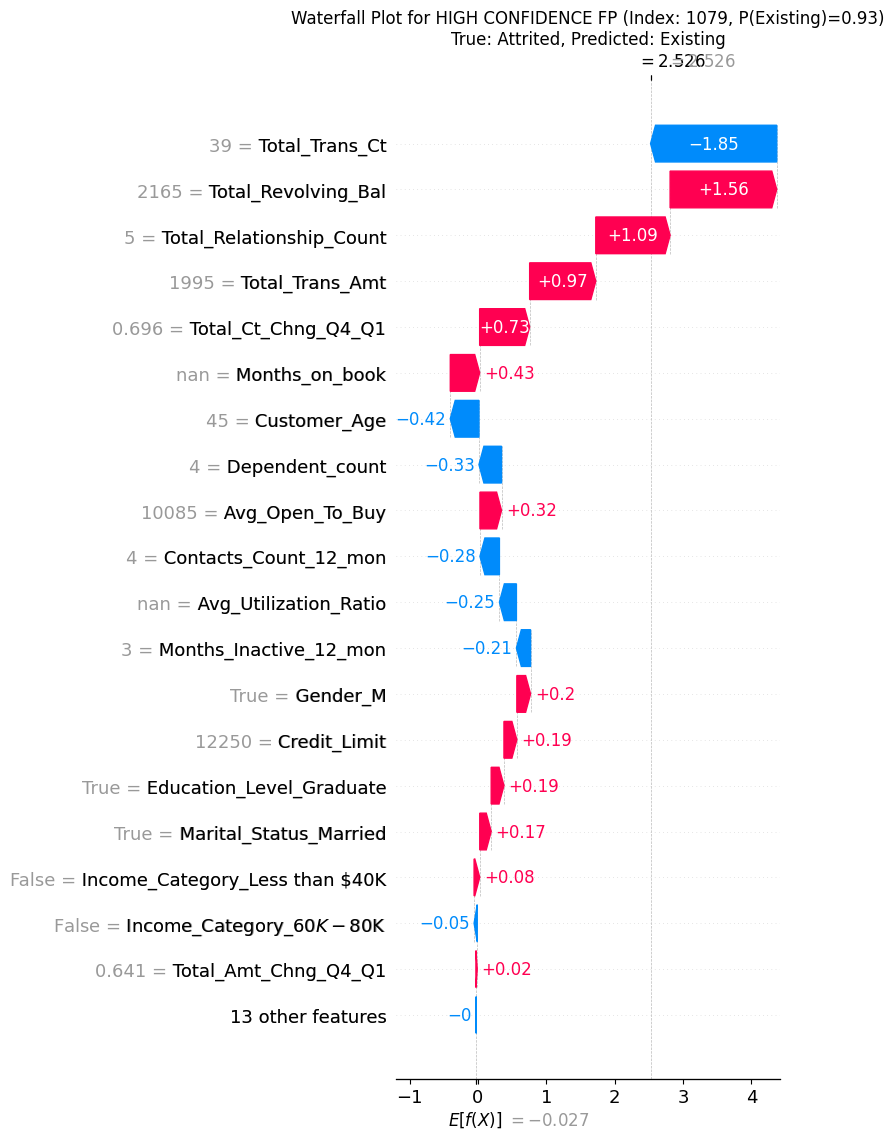


正在分析 Top 11 FP 案例 (原始索引: 1471)
模型預測為 'Existing' 的機率: 0.7850
真實標籤: Attrited (0), 預測標籤: Existing (1)


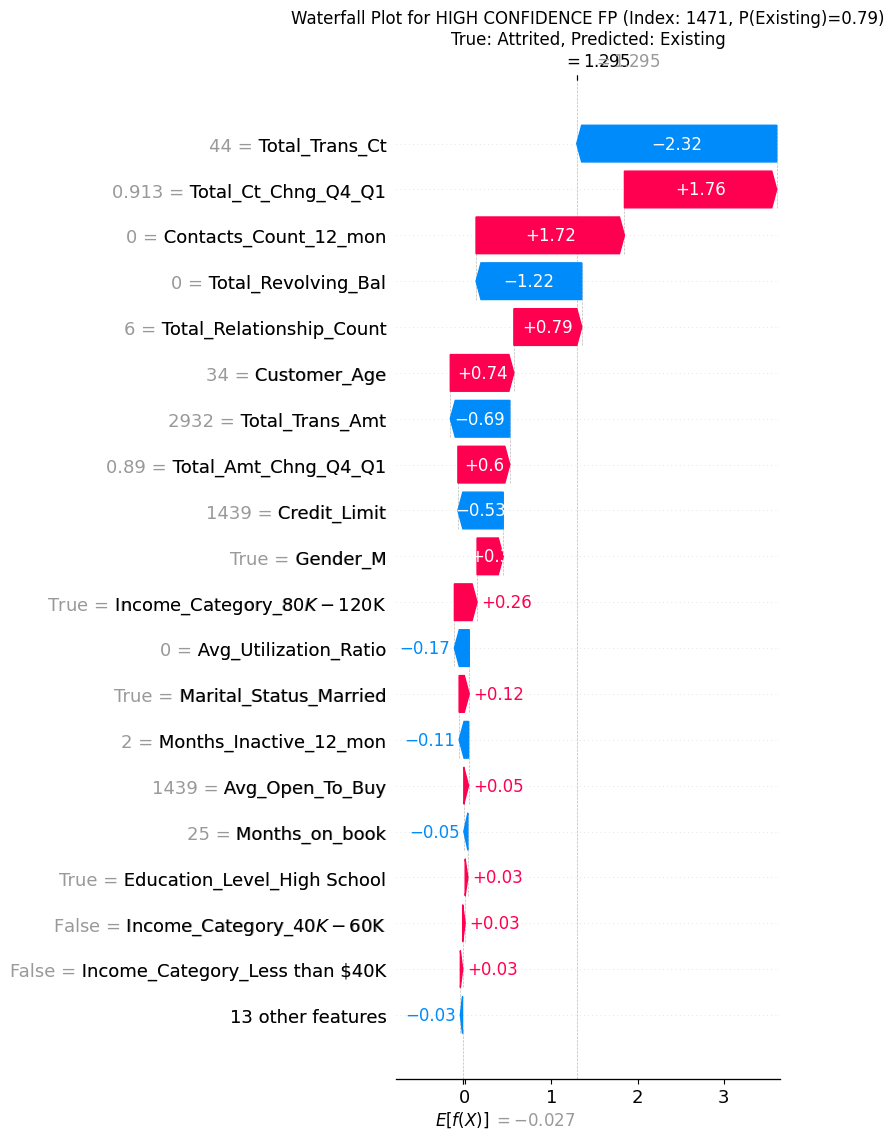


正在分析 Top 12 FP 案例 (原始索引: 1149)
模型預測為 'Existing' 的機率: 0.7730
真實標籤: Attrited (0), 預測標籤: Existing (1)


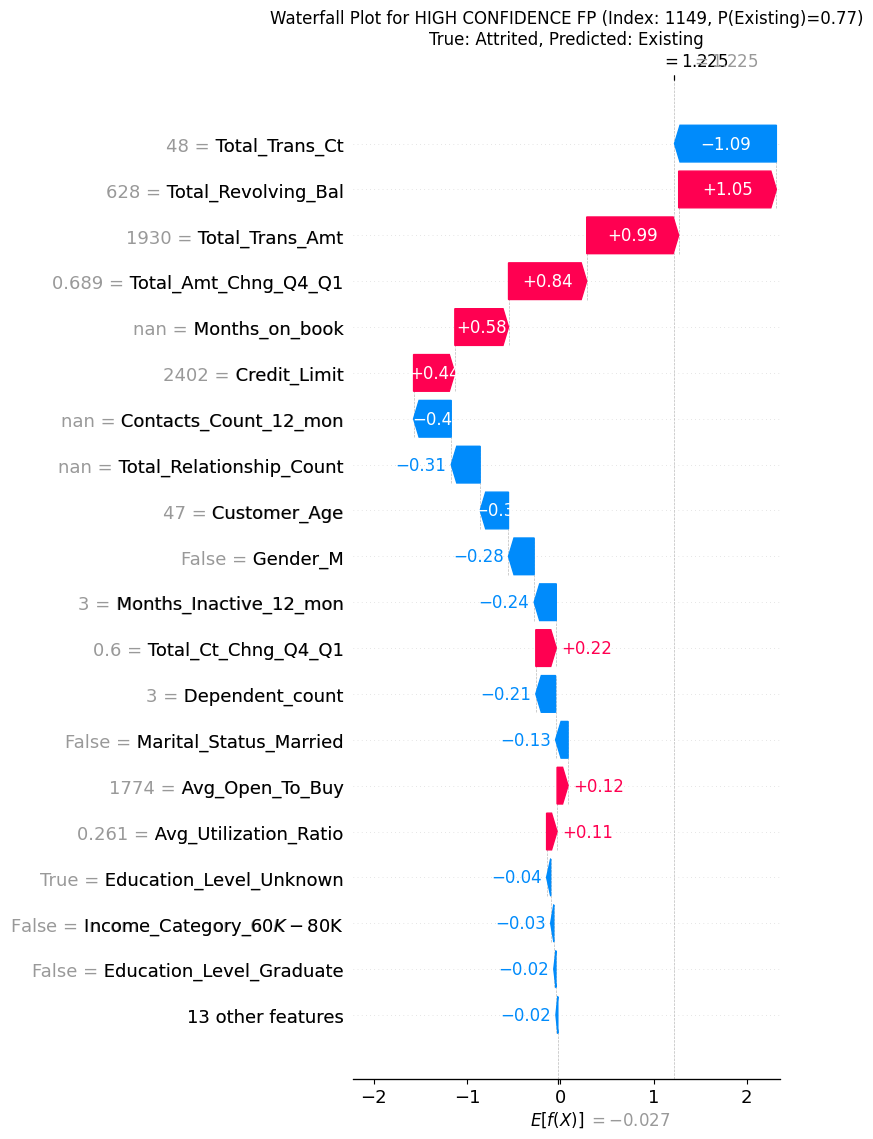


正在分析 Top 13 FP 案例 (原始索引: 1430)
模型預測為 'Existing' 的機率: 0.7567
真實標籤: Attrited (0), 預測標籤: Existing (1)


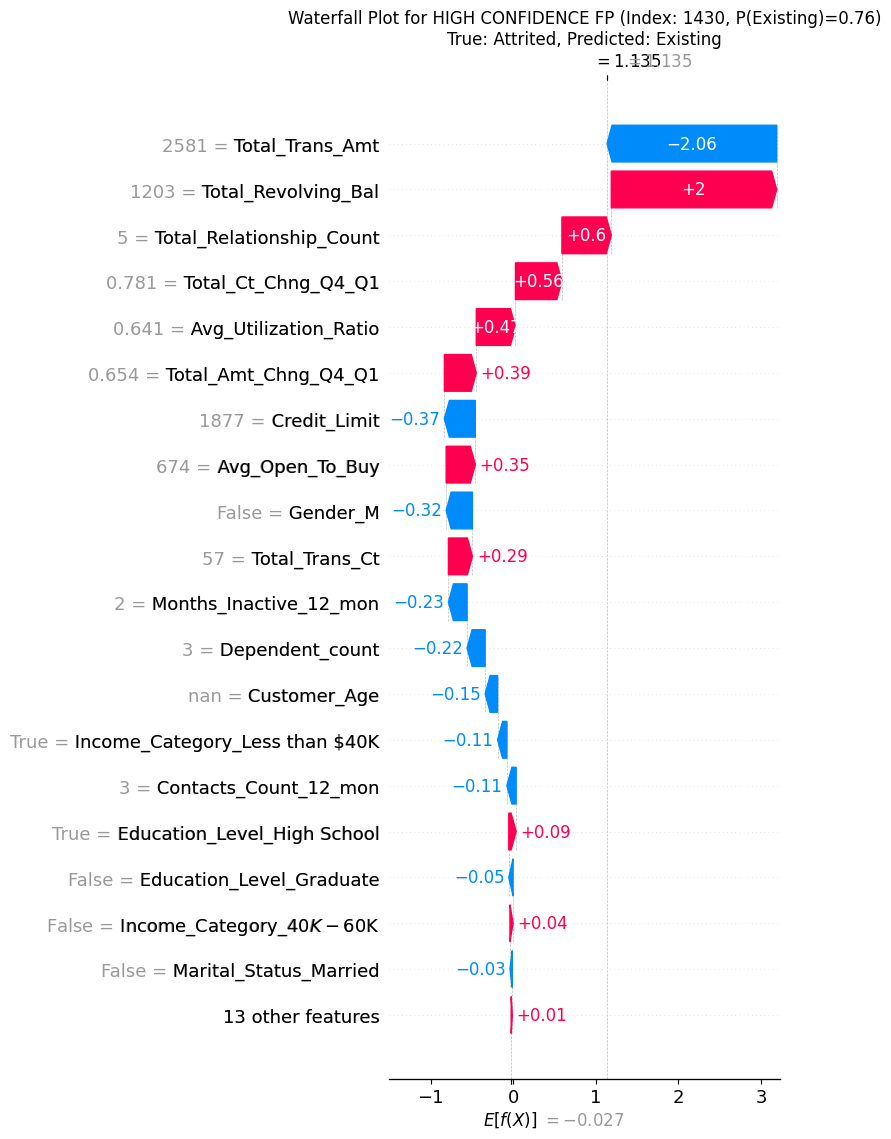


正在分析 Top 14 FP 案例 (原始索引: 1023)
模型預測為 'Existing' 的機率: 0.7458
真實標籤: Attrited (0), 預測標籤: Existing (1)


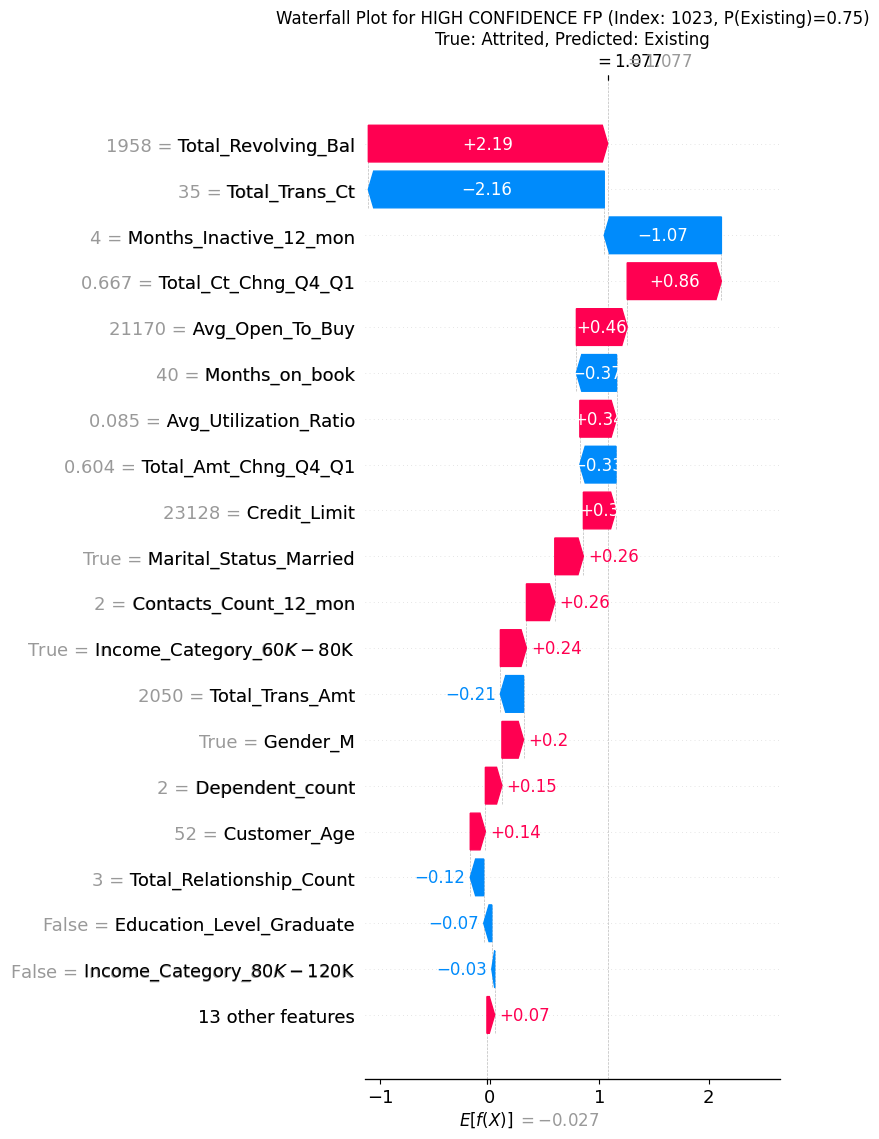


正在分析 Top 15 FP 案例 (原始索引: 1463)
模型預測為 'Existing' 的機率: 0.6328
真實標籤: Attrited (0), 預測標籤: Existing (1)


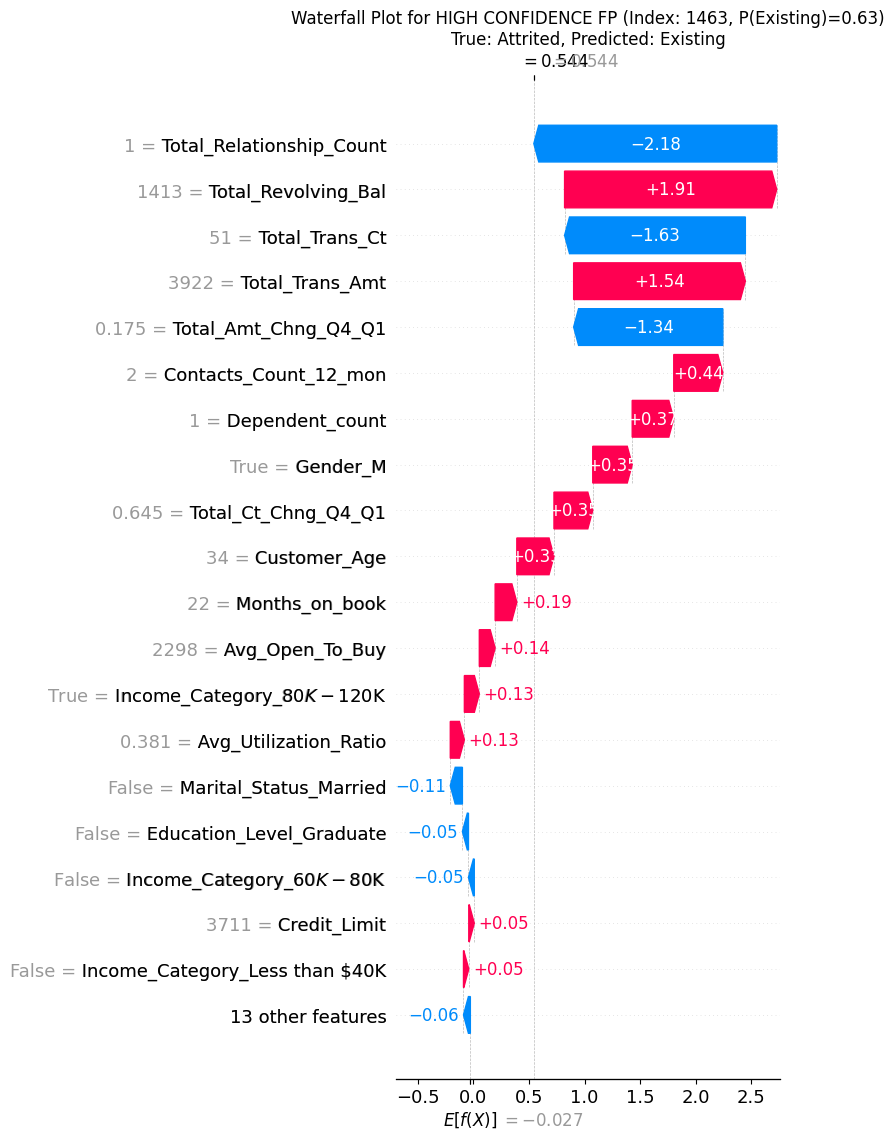


正在分析 Top 16 FP 案例 (原始索引: 1440)
模型預測為 'Existing' 的機率: 0.6116
真實標籤: Attrited (0), 預測標籤: Existing (1)


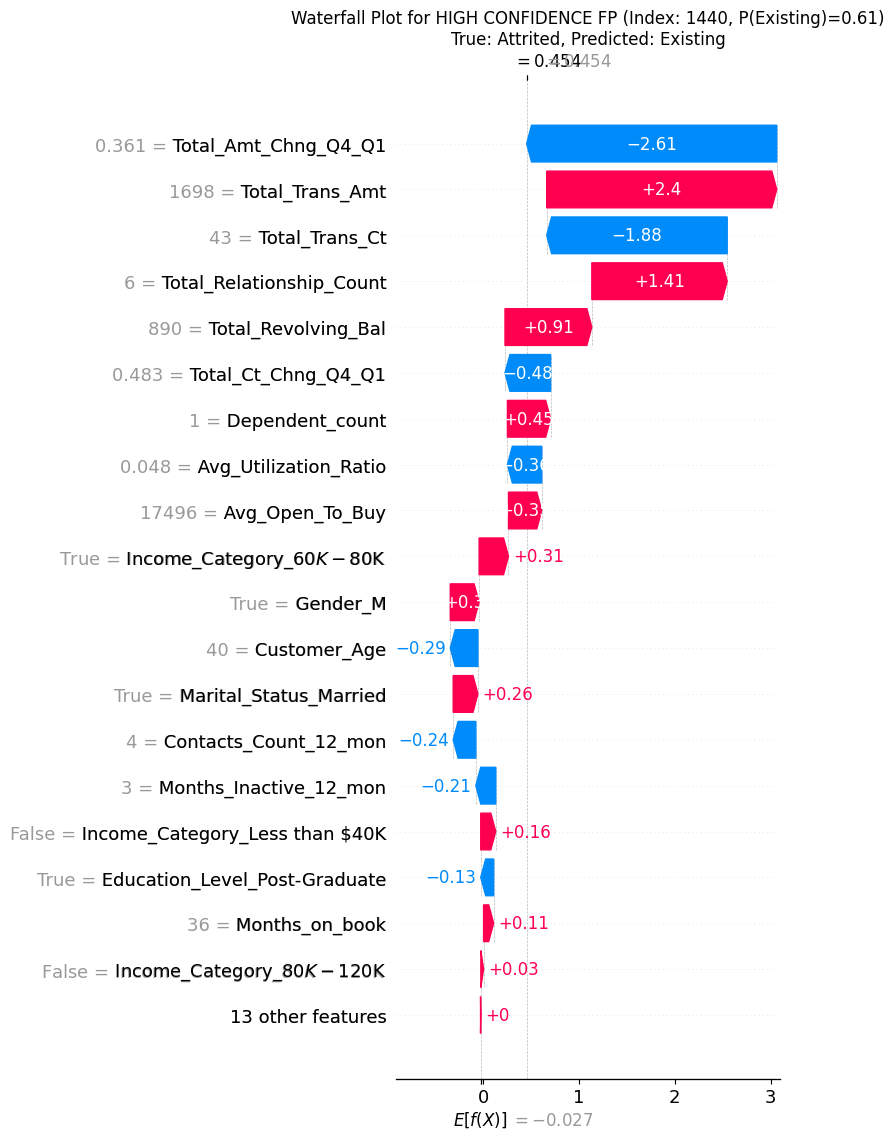


正在分析 Top 17 FP 案例 (原始索引: 897)
模型預測為 'Existing' 的機率: 0.6022
真實標籤: Attrited (0), 預測標籤: Existing (1)


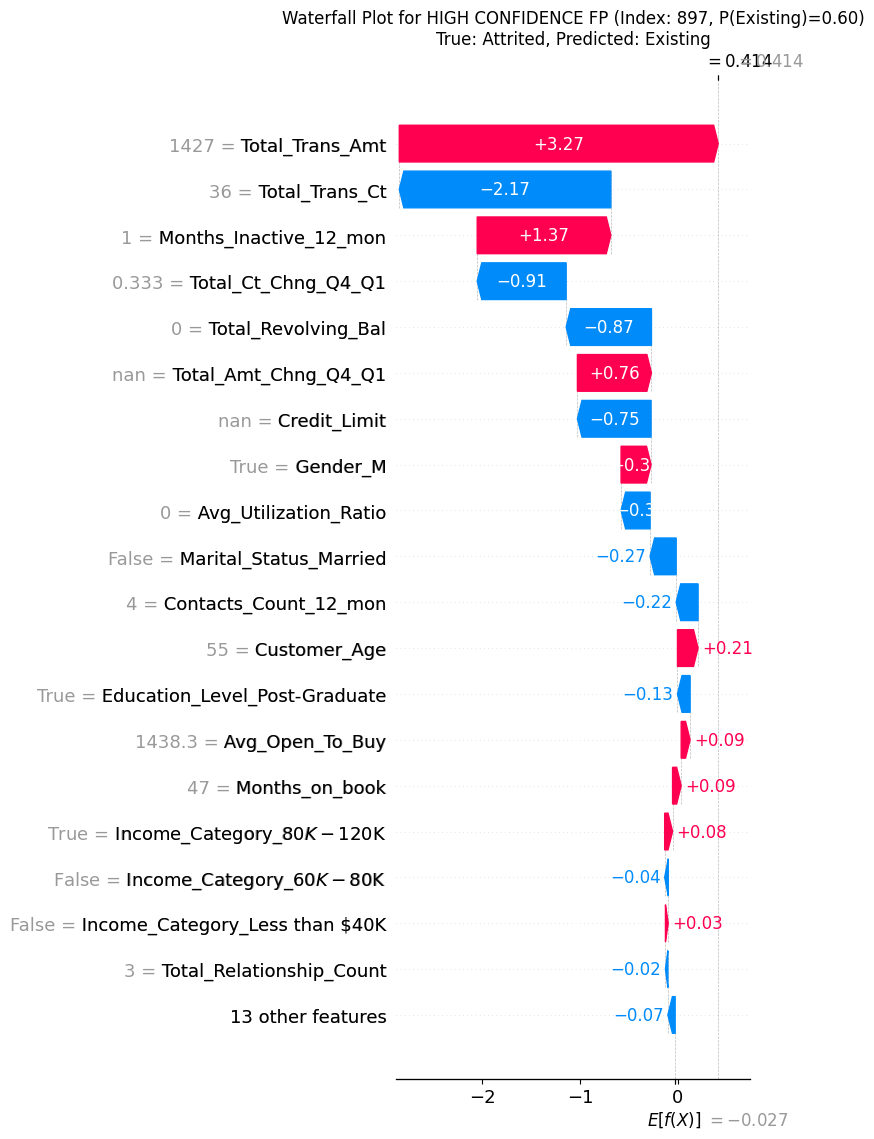


正在分析 Top 18 FP 案例 (原始索引: 581)
模型預測為 'Existing' 的機率: 0.5634
真實標籤: Attrited (0), 預測標籤: Existing (1)


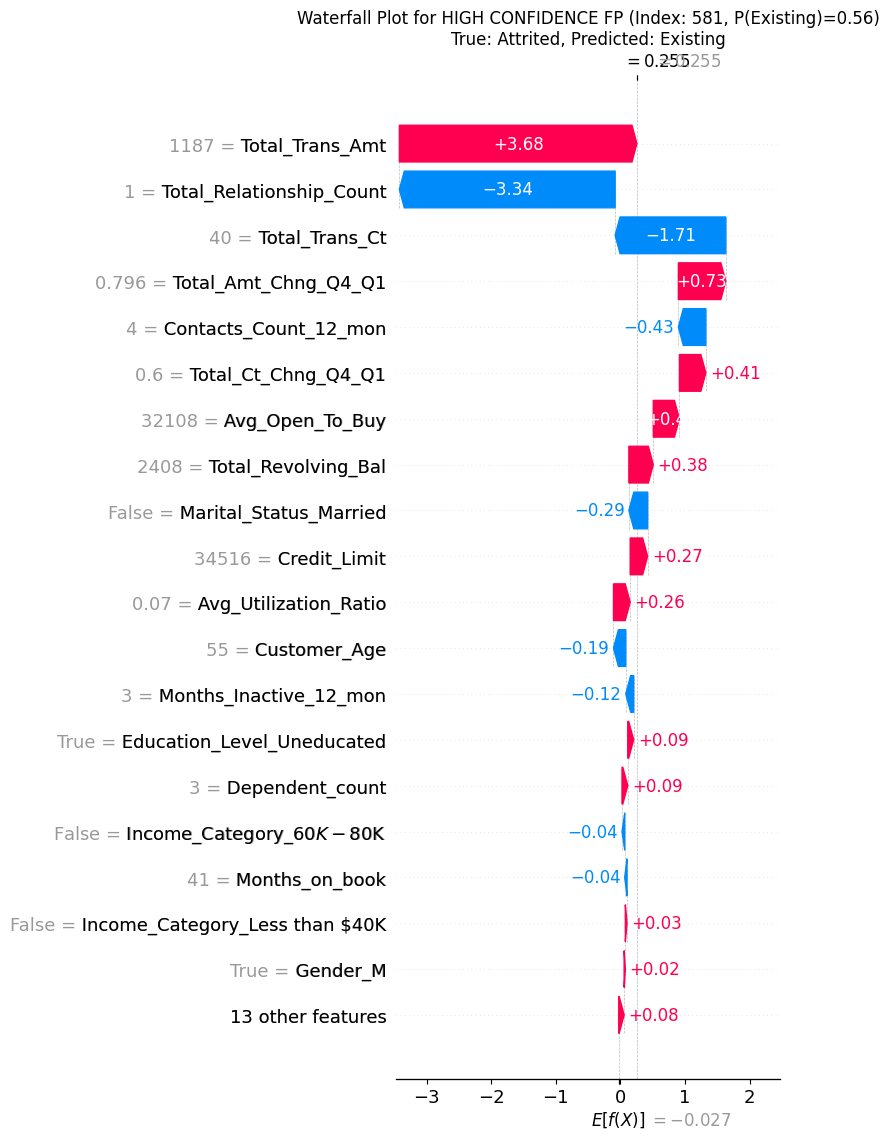


正在分析 Top 19 FP 案例 (原始索引: 630)
模型預測為 'Existing' 的機率: 0.5369
真實標籤: Attrited (0), 預測標籤: Existing (1)


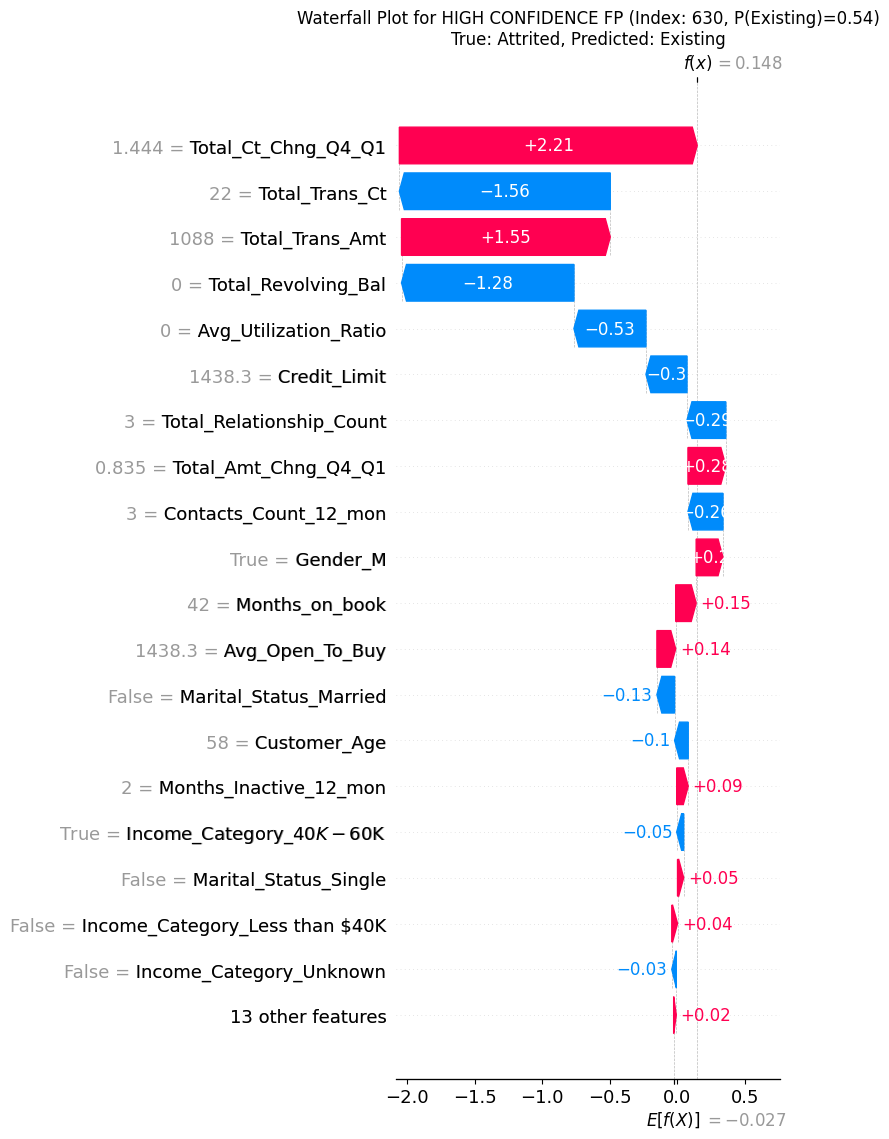


正在分析 Top 20 FP 案例 (原始索引: 486)
模型預測為 'Existing' 的機率: 0.5221
真實標籤: Attrited (0), 預測標籤: Existing (1)


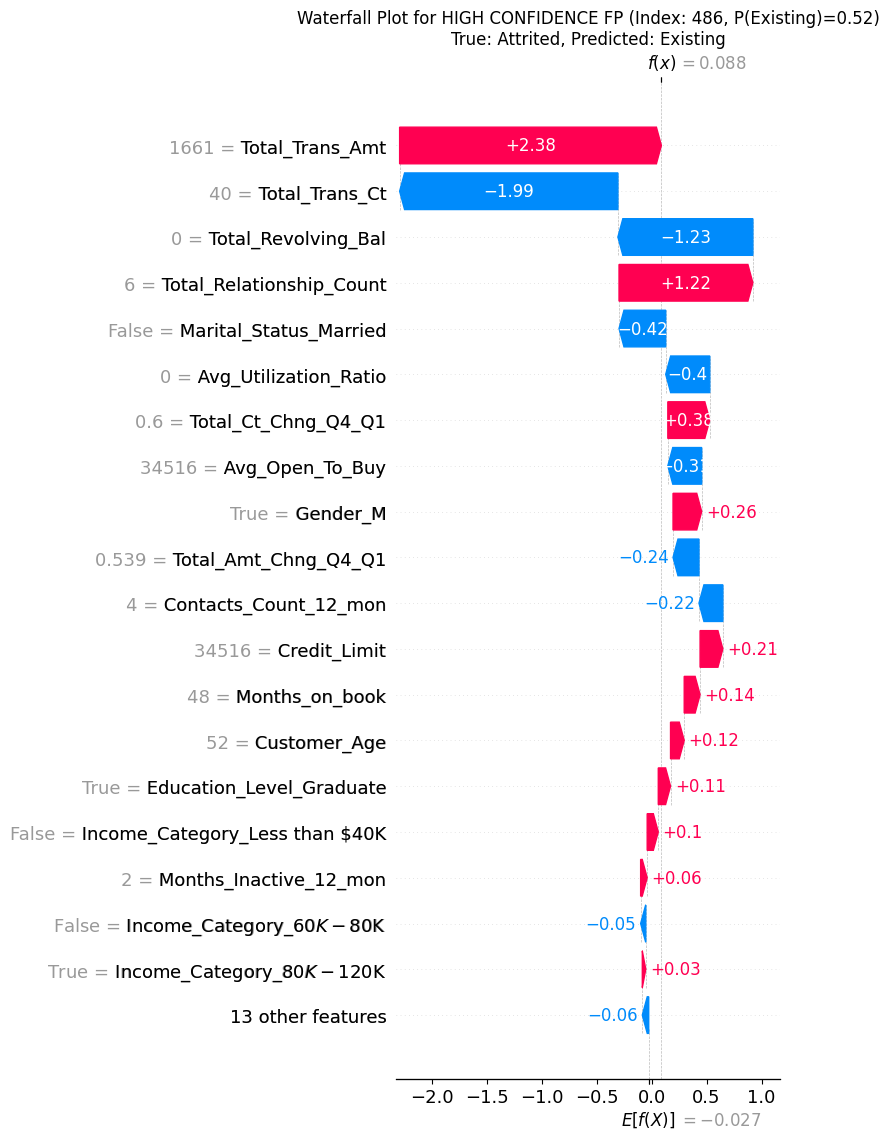

In [89]:
top_n_fp_cases = df_fp_confidence_sorted.head(N_top_fps)
print(f"--- 分析模型「錯得最自信」的 Top {N_top_fps} 個 FP 案例 ---")
print(top_n_fp_cases)
print("-" * 50)

# ---------------------------------------------------------------------------
# 4. 為選取的 Top N FP 案例繪製並分析 Waterfall Plots
# ---------------------------------------------------------------------------
label_map = {0: "Attrited", 1: "Existing"} # 用於標籤顯示

for i in range(len(top_n_fp_cases)):
    case_info = top_n_fp_cases.iloc[i]
    idx_to_analyze = int(case_info['fp_index']) # 轉換為整數索引
    confidence = case_info['probability_existing']
    
    actual_label = Y_test_encoded[idx_to_analyze]
    predicted_label = y_pred[idx_to_analyze] # 這應該是 1

    print(f"\n正在分析 Top {i+1} FP 案例 (原始索引: {idx_to_analyze})")
    print(f"模型預測為 'Existing' 的機率: {confidence:.4f}")
    print(f"真實標籤: {label_map[actual_label]} ({actual_label}), 預測標籤: {label_map[predicted_label]} ({predicted_label})")

    # Waterfall Plot
    shap_explanation_sample = shap.Explanation(
        values=shap_values[idx_to_analyze,:],
        base_values=explainer.expected_value,
        data=X_test_encoded.iloc[idx_to_analyze,:].values,
        feature_names=X_test_encoded.columns.tolist()
    )
    plt.figure(figsize=(10,8))
    shap.plots.waterfall(shap_explanation_sample, max_display=20, show=False)
    plt.title(f"Waterfall Plot for HIGH CONFIDENCE FP (Index: {idx_to_analyze}, P(Existing)={confidence:.2f})\nTrue: {label_map[actual_label]}, Predicted: {label_map[predicted_label]}", fontsize=12)
    plt.tight_layout()
    plt.show()


--- 繪製 Top 5 重要特徵的 SHAP 相依性圖 ---


<Figure size 1000x600 with 0 Axes>

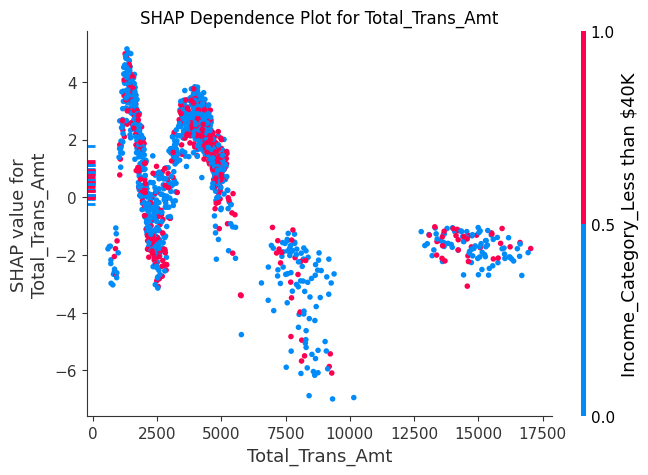

<Figure size 1000x600 with 0 Axes>

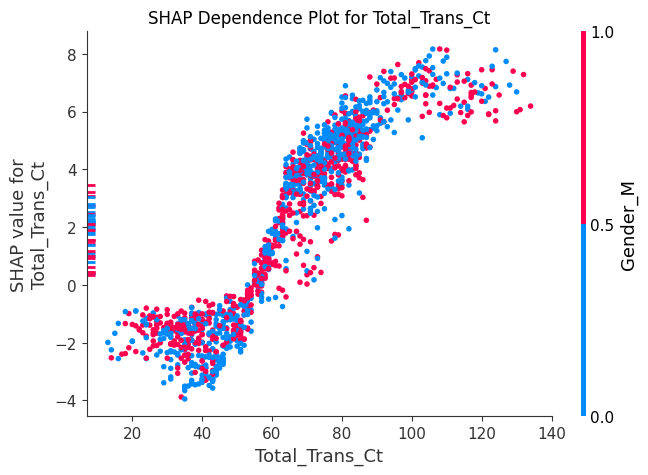

<Figure size 1000x600 with 0 Axes>

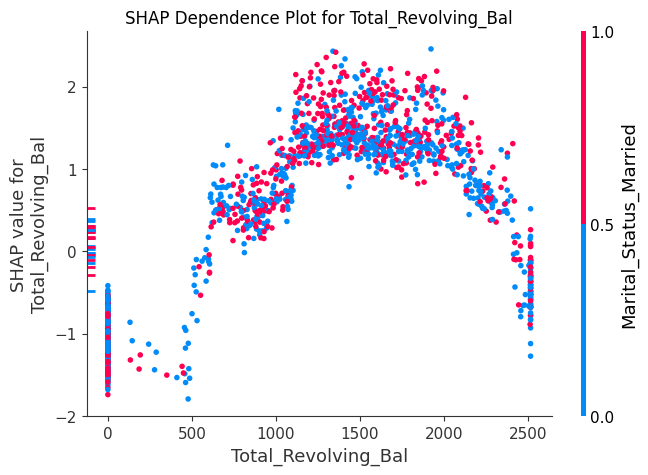

<Figure size 1000x600 with 0 Axes>

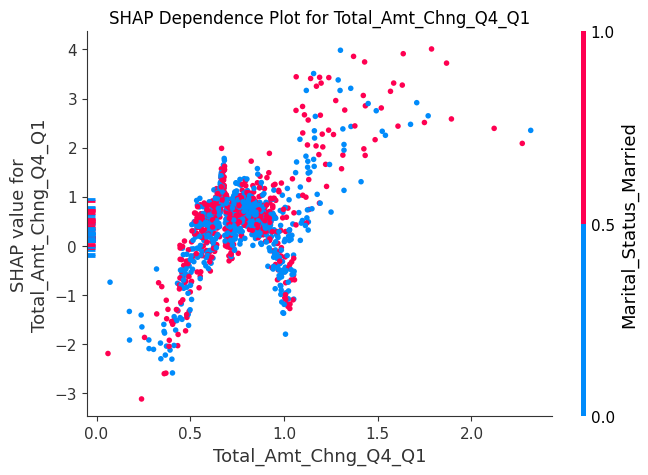

<Figure size 1000x600 with 0 Axes>

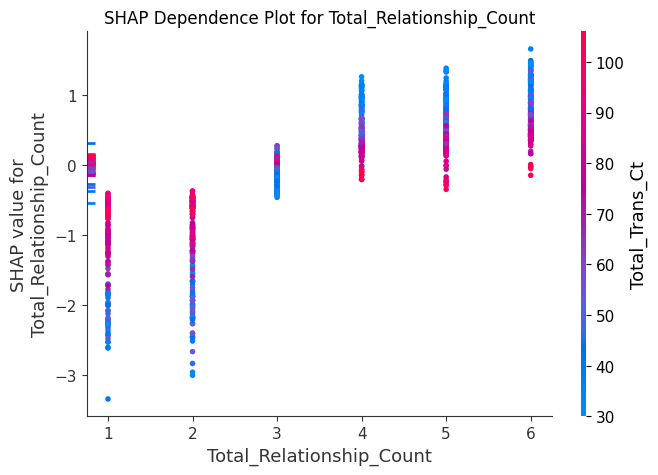

<Figure size 1000x600 with 0 Axes>

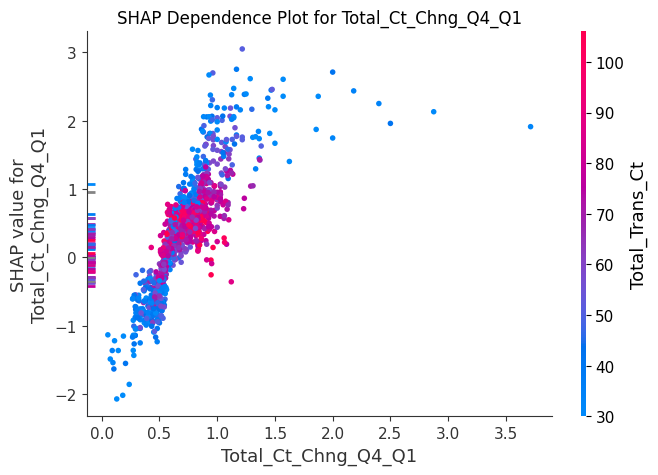

<Figure size 1000x600 with 0 Axes>

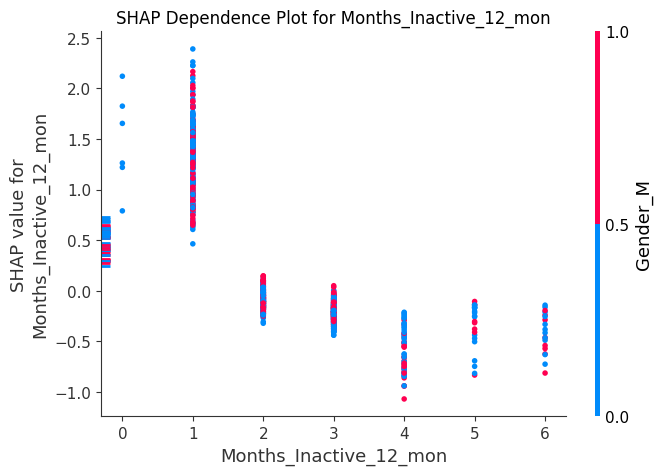

In [90]:

# 全局最重要的前五個特徵 (根據您的圖 image_829f39.png)
top_features = [
    'Total_Trans_Amt',
    'Total_Trans_Ct',
    'Total_Revolving_Bal',
    'Total_Amt_Chng_Q4_Q1',
    'Total_Relationship_Count',
    'Total_Ct_Chng_Q4_Q1',
    'Months_Inactive_12_mon',
    
]

print("\n--- 繪製 Top 5 重要特徵的 SHAP 相依性圖 ---")
for feature_name in top_features:
    if feature_name in X_test_encoded.columns:
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feature_name,
            shap_values,
            X_test_encoded,
            display_features=X_test_encoded,
            interaction_index="auto", # 讓 SHAP 自動選擇交互作用最強的特徵
            show=False
        )
        plt.title(f"SHAP Dependence Plot for {feature_name}")
        plt.show()
    else:
        print(f"警告：特徵 '{feature_name}' 不在 X_test_encoded 的欄位中。")

<Figure size 1000x600 with 0 Axes>

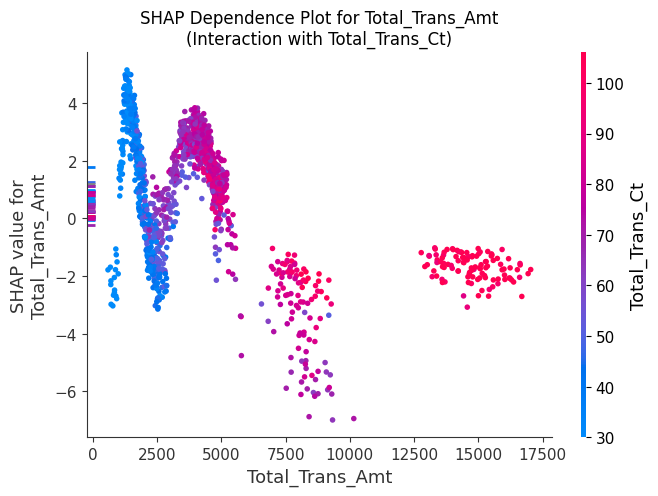

In [91]:
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    "Total_Trans_Amt",
    shap_values,
    X_test_encoded,
    display_features=X_test_encoded,
    interaction_index="Total_Trans_Ct",  # 指定交互特徵
    show=False
)
plt.title(f"SHAP Dependence Plot for Total_Trans_Amt\n(Interaction with Total_Trans_Ct)")
plt.show()

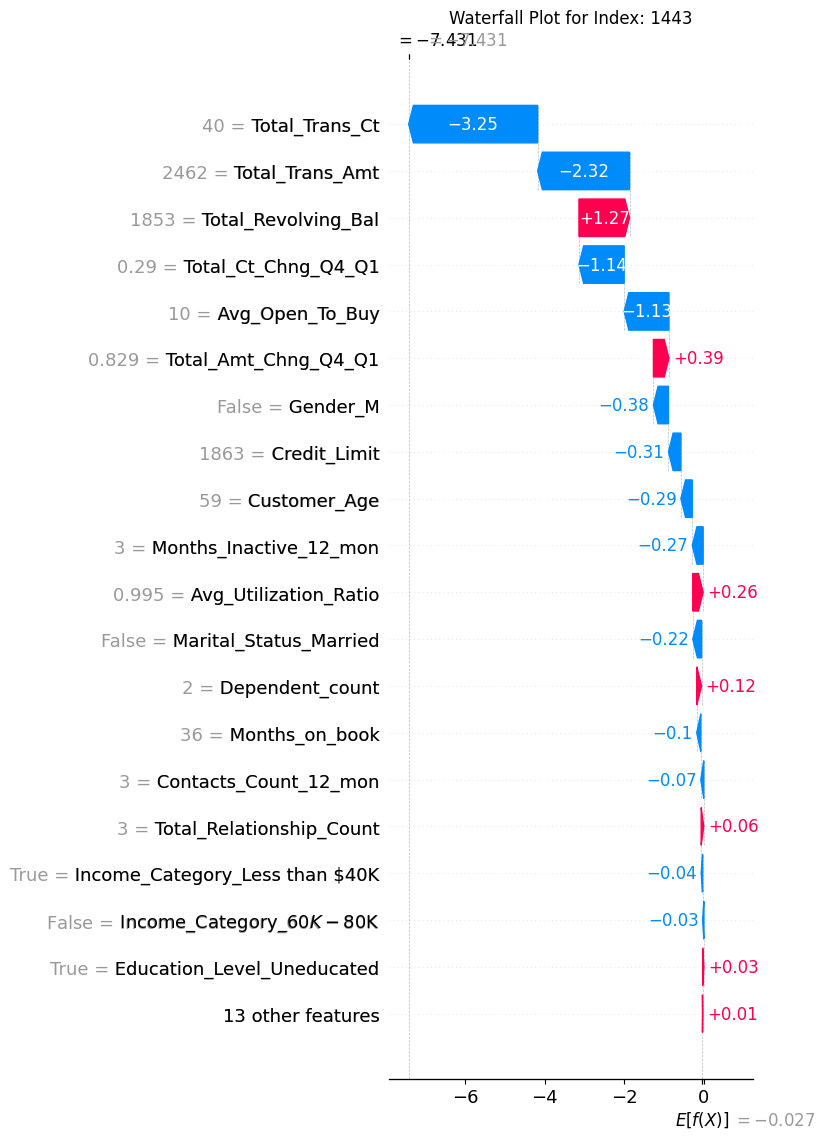

In [92]:
# Waterfall Plot
idx_to_analyze = 1443
shap_explanation_sample = shap.Explanation(
    values=shap_values[idx_to_analyze,:],
    base_values=explainer.expected_value,
    data=X_test_encoded.iloc[idx_to_analyze,:].values,
    feature_names=X_test_encoded.columns.tolist()
)
plt.figure(figsize=(10,8))
shap.plots.waterfall(shap_explanation_sample, max_display=20, show=False)
plt.title(f"Waterfall Plot for Index: {idx_to_analyze}", fontsize=12)
plt.tight_layout()
plt.show()

In [93]:
import pandas as pd
import numpy as np
import gower 

# --- 假設您已經準備好了以下變數 ---
# Y_test_encoded: NumPy array, 真實標籤 (0:流失, 1:留存)
# y_pred: NumPy array, 模型預測標籤 (0:預測流失, 1:預測留存)
# X_test: Pandas DataFrame, 對應的特徵數據 (索引應與 Y_test_encoded 和 y_pred 對齊)

# --- 您提供的程式碼 (用來識別索引) ---
fp_indices = np.where((y_pred == 1) & (Y_test_encoded == 0))[0]
print(f"找到 {len(fp_indices)} 個 FP 案例 (預測留存，實際流失)")

# TN (真陰性): 真實為流失 (0), 模型預測為流失 (0)
tn_indices = np.where((Y_test_encoded == 0) & (y_pred == 0))[0]
print(f"找到 {len(tn_indices)} 個 TN / 真流失案例 (預測流失，實際流失)")

# TP (真陽性): 真實為留存 (1), 模型預測為留存 (1)
tp_indices = np.where((Y_test_encoded == 1) & (y_pred == 1))[0]
print(f"找到 {len(tp_indices)} 個 TP / 真留存案例 (預測留存，實際留存)\n")


# --- 檢查是否有足夠的案例進行比較 ---
if len(fp_indices) == 0:
    print("沒有找到 FP 案例，分析結束。")
    exit()
if len(tn_indices) == 0:
    print("警告：沒有找到 TN (真流失) 案例，無法比較相似的 TN。")
if len(tp_indices) == 0:
    print("警告：沒有找到 TP (真留存) 案例，無法比較相似的 TP。")

# --- 從 X_test 中提取對應的數據子集 ---
# 這些 DataFrame 將直接用於 Gower 距離計算
df_fp = X_test.iloc[fp_indices]
df_tn = X_test.iloc[tn_indices] if len(tn_indices) > 0 else pd.DataFrame()
df_tp = X_test.iloc[tp_indices] if len(tp_indices) > 0 else pd.DataFrame()

# --- 特徵列表定義 ---
# !! 請根據您的數據集修改這些欄位 !!
# Gower 距離可以自動處理不同 dtypes，但明確指定類別特徵有助於確保正確性
try:
    if 'numerical_features' not in globals() or 'categorical_features' not in globals():
        print("警告：'numerical_features' 或 'categorical_features' 未定義。將使用示例欄位。")
        print("請務必將這些列表替換為您數據集中的實際欄位名稱！")
        # Gower 通常能較好地自動判斷，但明確指定 categorical_features 的布林遮罩會更穩健
        # 這裡我們假設 X_test 包含所有要比較的特徵
        all_feature_columns = X_test.columns.tolist() # 獲取 X_test 的所有欄位名
        # 您需要手動指定哪些是類別特徵
        # categorical_features = ['Gender', 'Marital_Status', ...] # 示例
        # 為了讓程式碼能運行，我們先做一個簡單的猜測
        categorical_features = [col for col in X_test.columns if X_test[col].dtype == 'object' or X_test[col].nunique() < 10] # 猜測，nunique < 10 可能不準確
        print(f"自動猜測的類別特徵 (請務必檢查並修改): {categorical_features}")
    
    # 創建一個布林遮罩，標記哪些欄位是類別特徵，供 gower.gower_matrix 使用
    # Gower 需要知道哪些欄位應被視為類別型
    # 確保 all_feature_columns 與 df_fp, df_tn, df_tp 的欄位順序一致
    # 通常情況下，它們都來自 X_test，所以欄位順序是一致的
    if not X_test.empty:
        cat_feature_mask = [col in categorical_features for col in X_test.columns]
    else:
        cat_feature_mask = [] # 如果 X_test 為空，則遮罩也為空

except Exception as e:
    print(f"定義特徵列表階段出錯: {e}")
    print("請確保 `X_test` 是 Pandas DataFrame，並且 `categorical_features` 列表已正確定義。")
    exit()


# --- 計算 Gower 距離並找出最近似的案例 ---
k_similar = 3
similar_cases_analysis = []

print(f"\n開始為 {len(df_fp)} 個 FP 案例尋找相似案例 (使用 Gower Distance)...")

# 只有在 df_fp 非空時才進行
if not df_fp.empty:
    for i, fp_original_idx in enumerate(df_fp.index):
        # Gower 需要 DataFrame 輸入，即使只有一行
        current_fp_df = df_fp.iloc[i:i+1]
        fp_original_data = df_fp.loc[fp_original_idx]

        analysis_entry = {
            'FP_Original_Index': fp_original_idx,
            'FP_Data_Series': fp_original_data
        }

        # 找出相似的 TN (真流失)
        if not df_tn.empty:
            # gower_matrix 會返回一個距離矩陣，我們需要第一行 (因為 current_fp_df 只有一行)
            distances_to_tn = gower.gower_matrix(current_fp_df, df_tn).flatten()
            closest_tn_relative_indices = distances_to_tn.argsort()[:min(k_similar, len(df_tn))]
            closest_tn_original_indices = df_tn.index[closest_tn_relative_indices]

            analysis_entry['Similar_TNs_True_Attrited'] = []
            for tn_rel_idx, tn_orig_idx in zip(closest_tn_relative_indices, closest_tn_original_indices):
                analysis_entry['Similar_TNs_True_Attrited'].append({
                    'TN_Original_Index': tn_orig_idx,
                    'TN_Data_Series': df_tn.loc[tn_orig_idx],
                    'Distance': distances_to_tn[tn_rel_idx] # Gower 距離
                })

        # 找出相似的 TP (真留存)
        if not df_tp.empty:
            distances_to_tp = gower.gower_matrix(current_fp_df, df_tp).flatten()
            closest_tp_relative_indices = distances_to_tp.argsort()[:min(k_similar, len(df_tp))]
            closest_tp_original_indices = df_tp.index[closest_tp_relative_indices]

            analysis_entry['Similar_TPs_True_Retained'] = []
            for tp_rel_idx, tp_orig_idx in zip(closest_tp_relative_indices, closest_tp_original_indices):
                analysis_entry['Similar_TPs_True_Retained'].append({
                    'TP_Original_Index': tp_orig_idx,
                    'TP_Data_Series': df_tp.loc[tp_orig_idx],
                    'Distance': distances_to_tp[tp_rel_idx] # Gower 距離
                })
        
        similar_cases_analysis.append(analysis_entry)
else:
    print("沒有 FP 數據可供分析。")

# --- 結果展示 (與之前範例相同) ---
print("\n--- 相似案例分析結果 (使用 Gower Distance) ---")
if not similar_cases_analysis:
    print("沒有可供展示的相似案例分析結果。")

for entry in similar_cases_analysis:
    print(f"\n\n=====================================================================")
    print(f"FP 案例 (原始索引: {entry['FP_Original_Index']}) --- [預測留存，實際流失]")
    print("---------------------------------------------------------------------")
    print("FP 特徵:")
    print(entry['FP_Data_Series'])
    print("---------------------------------------------------------------------")

    key_tn = 'Similar_TNs_True_Attrited'
    if key_tn in entry and entry[key_tn]:
        print(f"  找到 {len(entry[key_tn])} 個相似的 TN (真流失) 案例:")
        for tn_info in entry[key_tn]:
            print(f"    - TN 原始索引: {tn_info['TN_Original_Index']}, Gower 距離: {tn_info['Distance']:.4f} --- [預測流失，實際流失]")
    else:
        print("  未找到足夠的相似 TN (真流失) 案例。")
    print("---------------------------------------------------------------------")

    key_tp = 'Similar_TPs_True_Retained'
    if key_tp in entry and entry[key_tp]:
        print(f"  找到 {len(entry[key_tp])} 個相似的 TP (真留存) 案例:")
        for tp_info in entry[key_tp]:
            print(f"    - TP 原始索引: {tp_info['TP_Original_Index']}, Gower 距離: {tp_info['Distance']:.4f} --- [預測留存，實際留存]")
    else:
        print("  未找到足夠的相似 TP (真留存) 案例。")
    print("=====================================================================")

找到 20 個 FP 案例 (預測留存，實際流失)
找到 217 個 TN / 真流失案例 (預測流失，實際流失)
找到 1209 個 TP / 真留存案例 (預測留存，實際留存)

警告：'numerical_features' 或 'categorical_features' 未定義。將使用示例欄位。
請務必將這些列表替換為您數據集中的實際欄位名稱！
自動猜測的類別特徵 (請務必檢查並修改): ['Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']

開始為 20 個 FP 案例尋找相似案例 (使用 Gower Distance)...

--- 相似案例分析結果 (使用 Gower Distance) ---


FP 案例 (原始索引: 463) --- [預測留存，實際流失]
---------------------------------------------------------------------
FP 特徵:
Customer_Age                        48.0
Gender                                 M
Dependent_count                      2.0
Education_Level                  College
Marital_Status                  Divorced
Income_Category             $80K - $120K
Card_Category                       Blue
Months_on_book                      40.0
Total_Relationship_Count             4.0
Months_Inactive_12_mon               3.0
Contacts_Co

In [100]:
import seaborn as sns 

--- 各 Total_Trans_Amt 細分群組的客戶數量 ---
Amt_Cluster_Detailed
C1 (0-1.5k, Peak 1)           227
C2 (1.5k-2.5k, Valley 1)      215
C3 (2.5k-4k, Peak 2)          289
C4 (4k-5k, Valley 2)          425
C5 (7.5k-10k, Deep Valley)     89
C6 (12.5k+, High Amt)         111
Other                         116
Name: count, dtype: int64
--------------------------------------------------

--- 各群組的 Customer_Age 統計描述 ---
                            count       mean       std   min    25%   50%  \
Amt_Cluster_Detailed                                                        
C1 (0-1.5k, Peak 1)         219.0  49.283105  8.239658  26.0  43.50  50.0   
C2 (1.5k-2.5k, Valley 1)    206.0  45.135922  9.783060  26.0  37.25  47.0   
C3 (2.5k-4k, Peak 2)        279.0  44.584229  8.257059  26.0  39.00  45.0   
C4 (4k-5k, Valley 2)        405.0  46.683951  6.870360  29.0  41.00  47.0   
C5 (7.5k-10k, Deep Valley)   85.0  45.658824  6.677170  29.0  41.00  45.0   
C6 (12.5k+, High Amt)       109.0  46.431193  7.934182  2

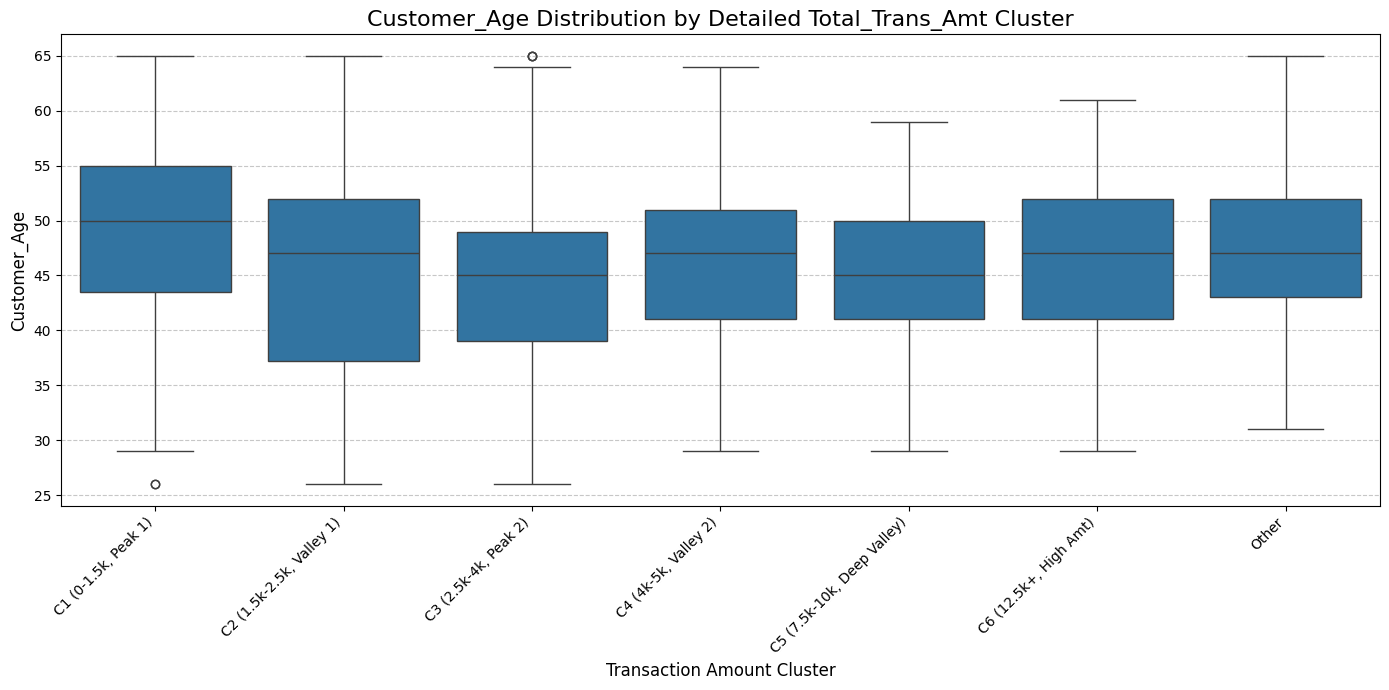


--- 各群組的 Total_Revolving_Bal 統計描述 ---
                            count         mean         std  min      25%  \
Amt_Cluster_Detailed                                                       
C1 (0-1.5k, Peak 1)         227.0  1271.185022  787.142930  0.0   781.00   
C2 (1.5k-2.5k, Valley 1)    211.0   930.805687  840.518601  0.0     0.00   
C3 (2.5k-4k, Peak 2)        283.0  1061.526502  794.816234  0.0     0.00   
C4 (4k-5k, Valley 2)        415.0  1159.626506  791.704968  0.0   620.50   
C5 (7.5k-10k, Deep Valley)   88.0  1294.602273  904.201414  0.0   331.50   
C6 (12.5k+, High Amt)       109.0  1344.807339  770.685115  0.0  1073.00   
Other                       110.0  1183.345455  743.061365  0.0   761.75   

                               50%      75%     max  
Amt_Cluster_Detailed                                 
C1 (0-1.5k, Peak 1)         1385.0  1856.00  2517.0  
C2 (1.5k-2.5k, Valley 1)     929.0  1577.00  2517.0  
C3 (2.5k-4k, Peak 2)        1190.0  1628.00  2517.0  
C4 (4k

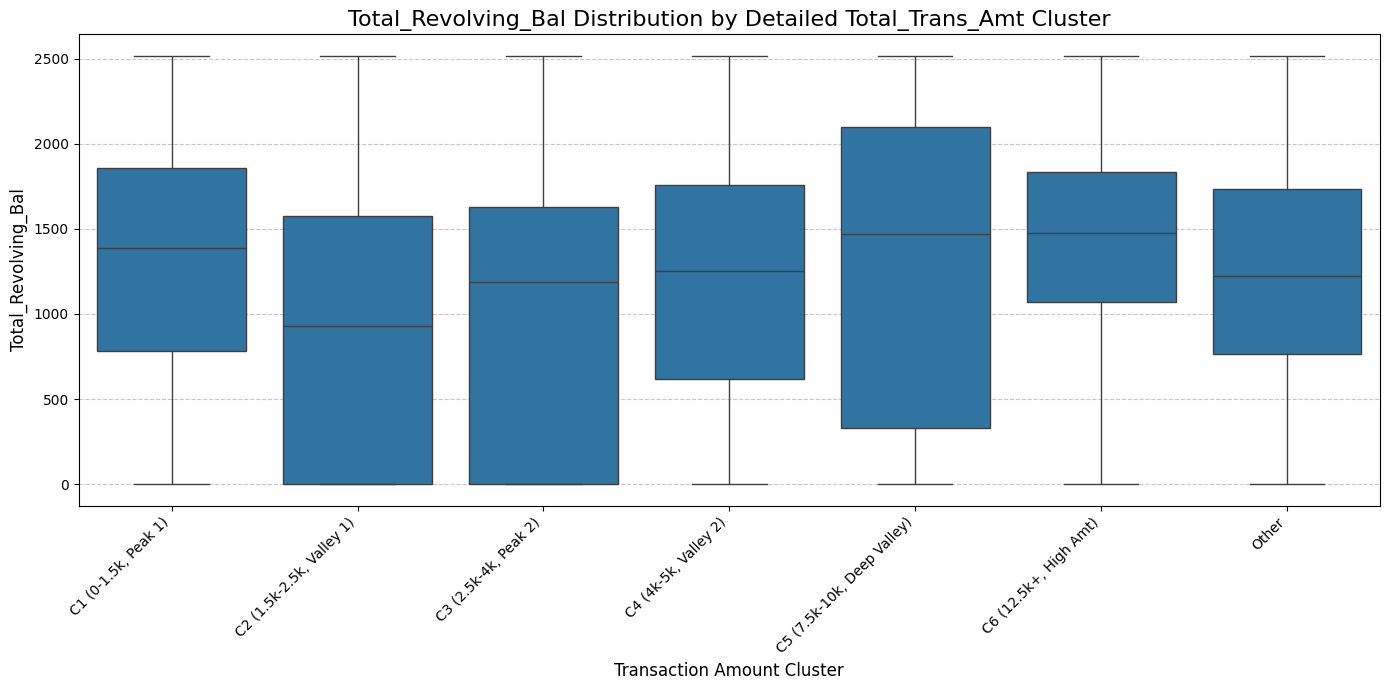


--- 各群組的 Total_Trans_Ct 統計描述 ---
                            count        mean        std   min     25%    50%  \
Amt_Cluster_Detailed                                                            
C1 (0-1.5k, Peak 1)         219.0   33.945205   8.863735  13.0   28.00   34.0   
C2 (1.5k-2.5k, Valley 1)    209.0   46.019139   9.075517  23.0   40.00   45.0   
C3 (2.5k-4k, Peak 2)        283.0   62.816254  11.818432  29.0   56.00   63.0   
C4 (4k-5k, Valley 2)        409.0   75.396088   8.762643  49.0   70.00   76.0   
C5 (7.5k-10k, Deep Valley)   86.0   84.279070  13.545263  51.0   76.25   84.0   
C6 (12.5k+, High Amt)       109.0  109.743119  10.597347  87.0  102.00  109.0   
Other                       115.0   72.686957  17.211464  15.0   66.00   76.0   

                               75%    max  
Amt_Cluster_Detailed                       
C1 (0-1.5k, Peak 1)          38.00   67.0  
C2 (1.5k-2.5k, Valley 1)     52.00   74.0  
C3 (2.5k-4k, Peak 2)         71.00   87.0  
C4 (4k-5k, Valle

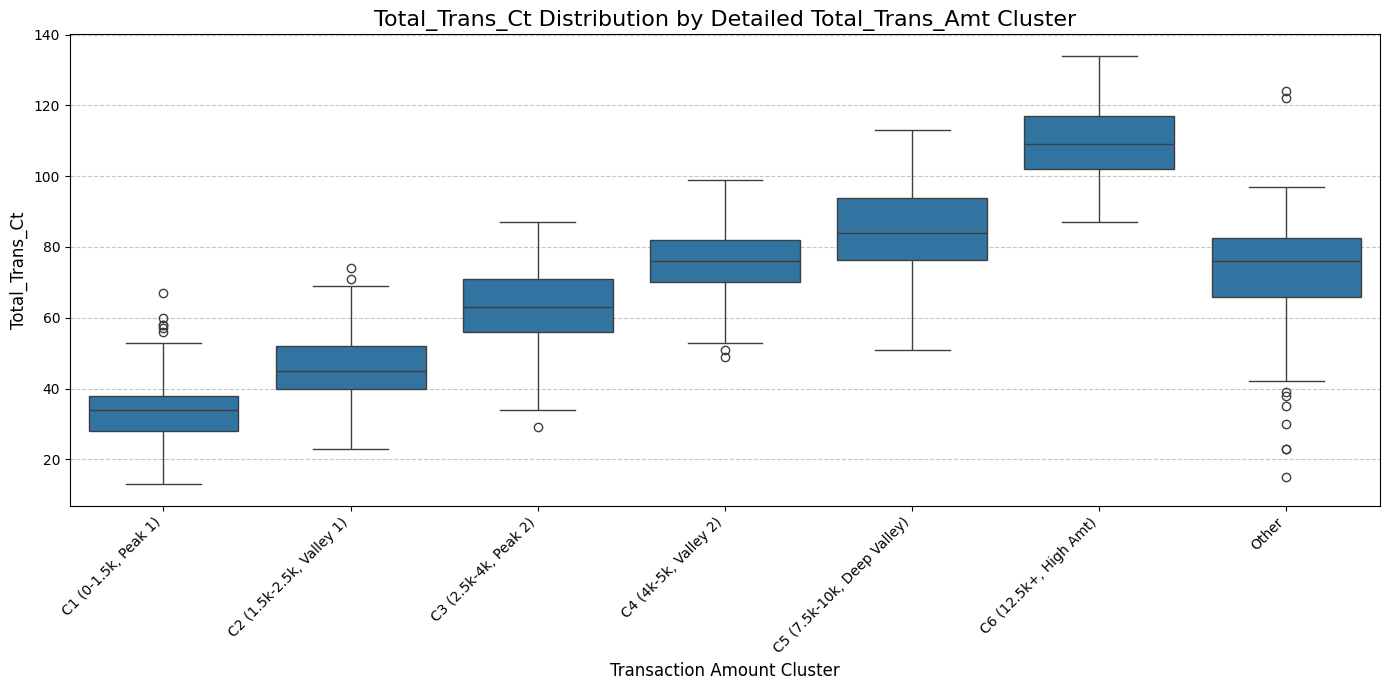


--- 各群組的 Months_on_book 統計描述 ---
                            count       mean       std   min    25%   50%  \
Amt_Cluster_Detailed                                                        
C1 (0-1.5k, Peak 1)         222.0  38.166667  8.273830  13.0  35.00  36.0   
C2 (1.5k-2.5k, Valley 1)    206.0  34.616505  9.108212  13.0  29.00  36.0   
C3 (2.5k-4k, Peak 2)        285.0  34.017544  8.116865  13.0  29.00  36.0   
C4 (4k-5k, Valley 2)        414.0  36.077295  7.106510  13.0  32.00  36.0   
C5 (7.5k-10k, Deep Valley)   85.0  35.776471  7.261078  13.0  32.00  36.0   
C6 (12.5k+, High Amt)       108.0  36.500000  7.527520  14.0  33.75  36.0   
Other                       111.0  36.639640  7.687999  13.0  33.00  36.0   

                             75%   max  
Amt_Cluster_Detailed                    
C1 (0-1.5k, Peak 1)         44.0  56.0  
C2 (1.5k-2.5k, Valley 1)    40.0  56.0  
C3 (2.5k-4k, Peak 2)        38.0  56.0  
C4 (4k-5k, Valley 2)        40.0  56.0  
C5 (7.5k-10k, Deep Valley)

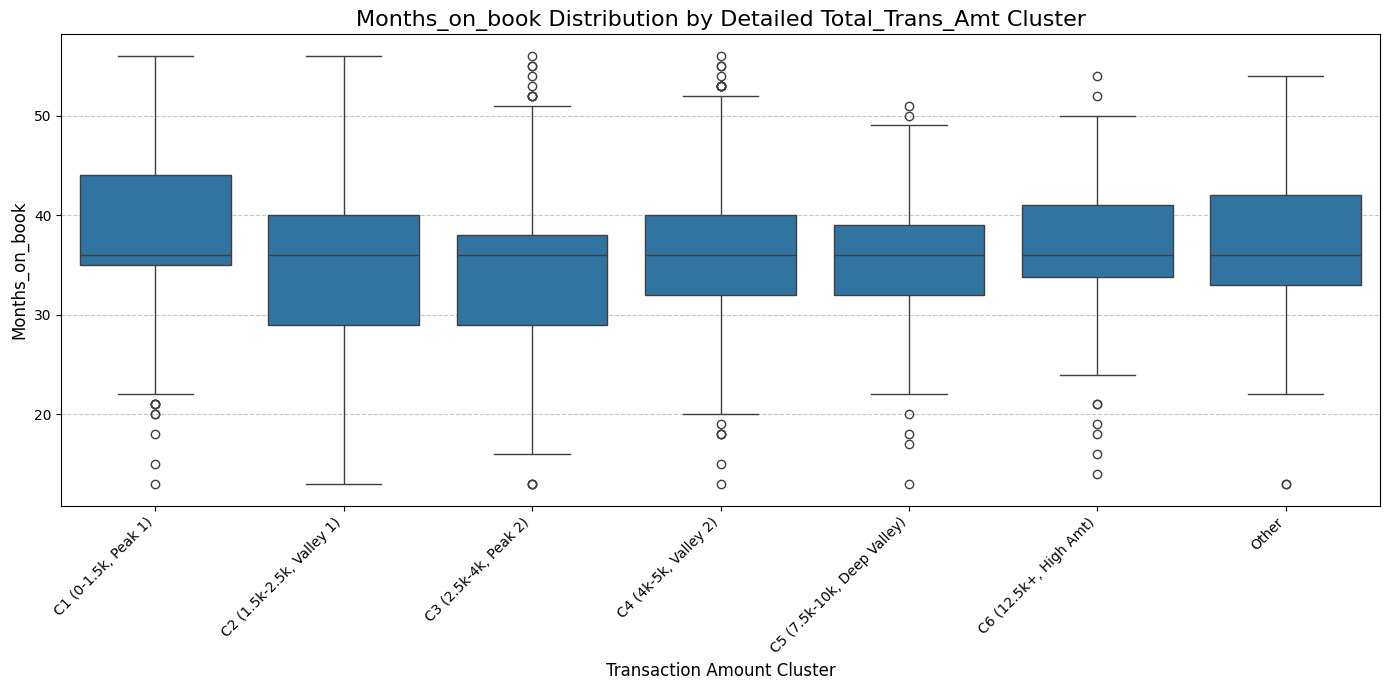


--- 各群組的 Credit_Limit 統計描述 ---
                            count          mean           std     min  \
Amt_Cluster_Detailed                                                    
C1 (0-1.5k, Peak 1)         218.0  10146.094495   9851.841630  1438.3   
C2 (1.5k-2.5k, Valley 1)    207.0   7621.328986   8771.856069  1438.3   
C3 (2.5k-4k, Peak 2)        281.0  10083.198221   9999.490186  1438.3   
C4 (4k-5k, Valley 2)        412.0   6130.069903   7428.539309  1438.3   
C5 (7.5k-10k, Deep Valley)   87.0  15189.758621  11151.405126  2000.0   
C6 (12.5k+, High Amt)       111.0  13635.351351  10012.169344  3152.0   
Other                       110.0   8127.050000   9739.344786  1438.3   

                                25%      50%       75%      max  
Amt_Cluster_Detailed                                             
C1 (0-1.5k, Peak 1)         2938.25   5567.5  13753.50  34516.0  
C2 (1.5k-2.5k, Valley 1)    1995.00   3899.0   8849.00  34516.0  
C3 (2.5k-4k, Peak 2)        2618.00   5719.0  

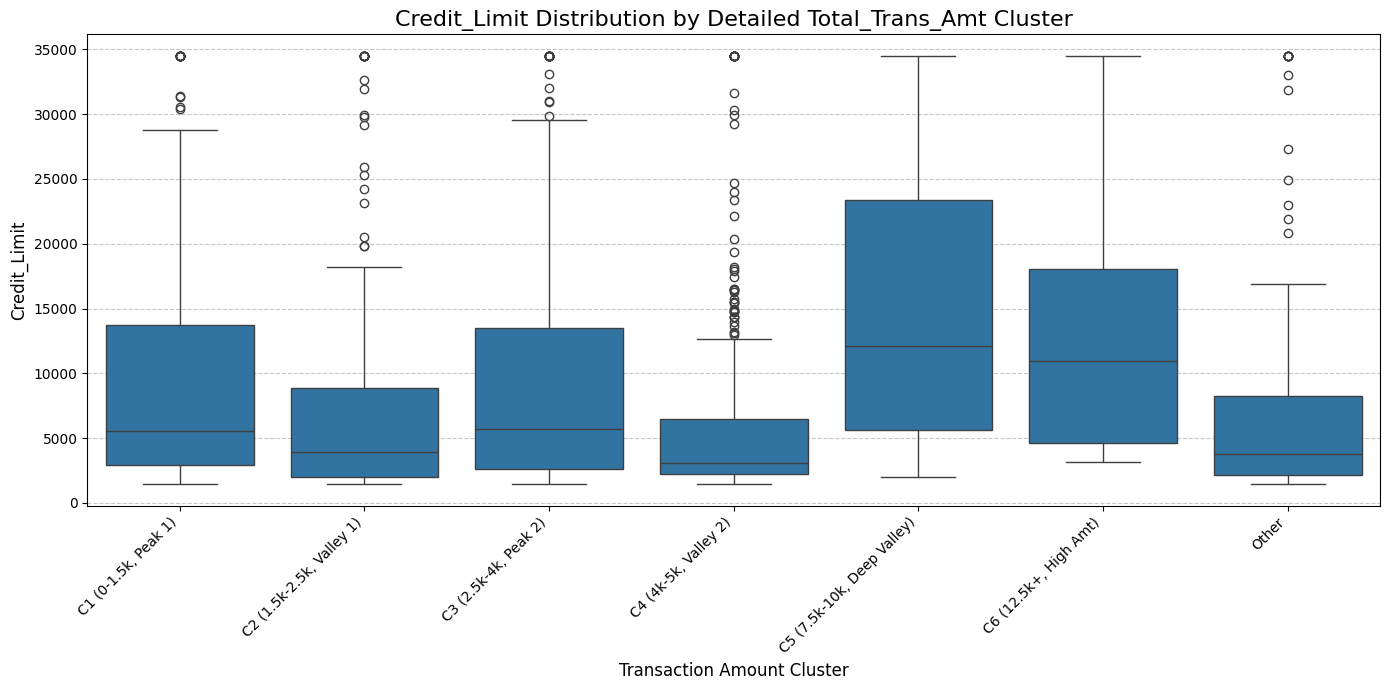


--- 各群組的 Months_Inactive_12_mon 統計描述 ---
                            count      mean       std  min  25%  50%  75%  max
Amt_Cluster_Detailed                                                          
C1 (0-1.5k, Peak 1)         221.0  2.230769  0.946839  1.0  1.0  2.0  3.0  6.0
C2 (1.5k-2.5k, Valley 1)    208.0  2.389423  1.057425  0.0  2.0  2.0  3.0  6.0
C3 (2.5k-4k, Peak 2)        282.0  2.294326  0.951812  1.0  2.0  2.0  3.0  6.0
C4 (4k-5k, Valley 2)        407.0  2.339066  1.108864  0.0  2.0  2.0  3.0  6.0
C5 (7.5k-10k, Deep Valley)   86.0  2.418605  0.999590  1.0  2.0  2.0  3.0  6.0
C6 (12.5k+, High Amt)       108.0  2.212963  0.927774  1.0  2.0  2.0  3.0  6.0
Other                       112.0  2.383929  0.892870  1.0  2.0  2.0  3.0  5.0


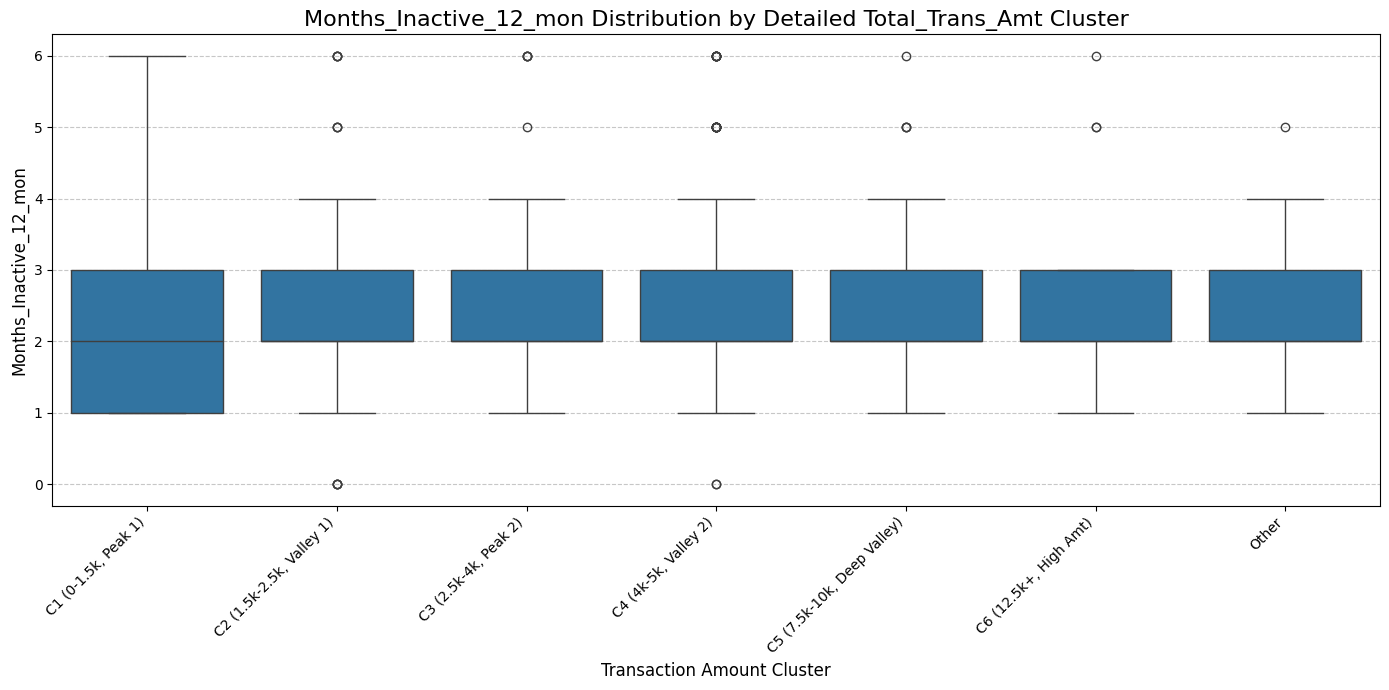


--- 各群組的 Total_Relationship_Count 統計描述 ---
                            count      mean       std  min   25%  50%  75%  \
Amt_Cluster_Detailed                                                         
C1 (0-1.5k, Peak 1)         222.0  4.162162  1.388645  1.0  3.00  4.0  5.0   
C2 (1.5k-2.5k, Valley 1)    213.0  3.985915  1.438942  1.0  3.00  4.0  5.0   
C3 (2.5k-4k, Peak 2)        275.0  4.203636  1.427821  1.0  3.00  4.0  5.0   
C4 (4k-5k, Valley 2)        413.0  4.019370  1.526342  1.0  3.00  4.0  5.0   
C5 (7.5k-10k, Deep Valley)   86.0  2.069767  1.125017  1.0  1.00  2.0  2.0   
C6 (12.5k+, High Amt)       106.0  2.500000  1.332738  1.0  1.25  2.0  3.0   
Other                       112.0  3.383929  1.606549  1.0  2.00  3.0  5.0   

                            max  
Amt_Cluster_Detailed             
C1 (0-1.5k, Peak 1)         6.0  
C2 (1.5k-2.5k, Valley 1)    6.0  
C3 (2.5k-4k, Peak 2)        6.0  
C4 (4k-5k, Valley 2)        6.0  
C5 (7.5k-10k, Deep Valley)  6.0  
C6 (12.5k+, Hig

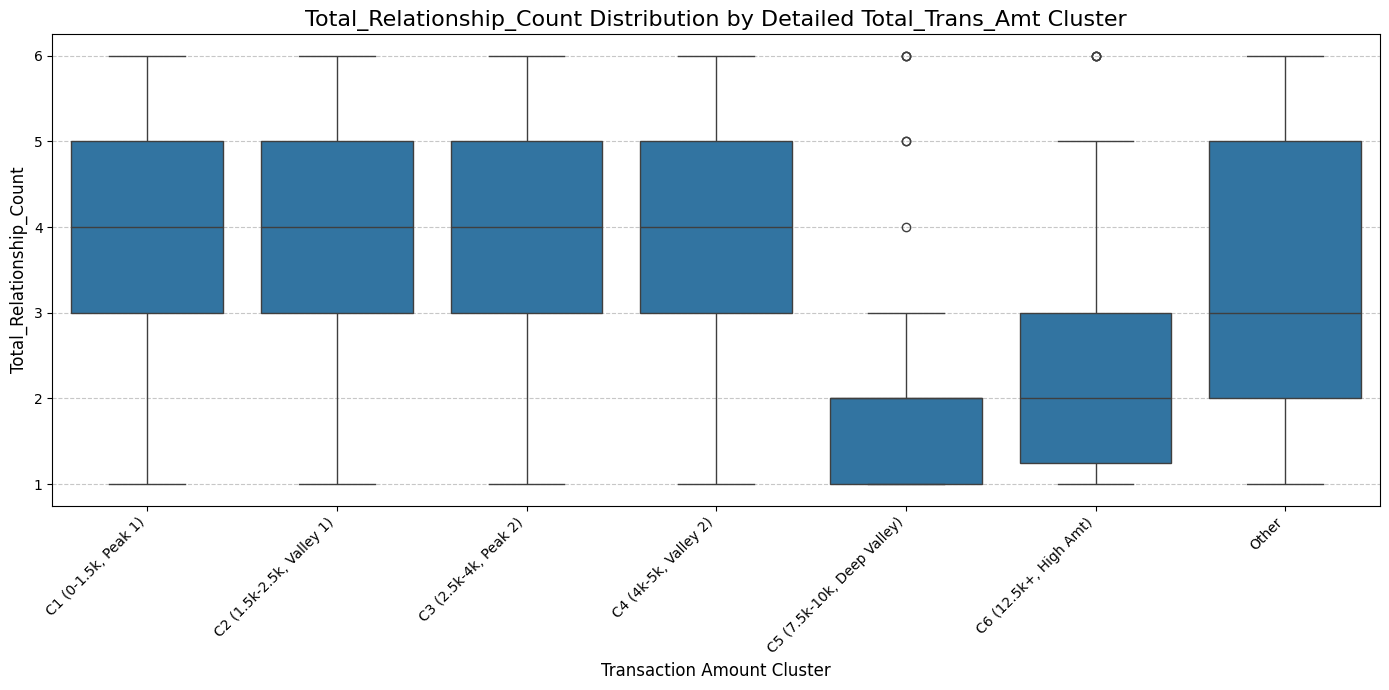


--- 各群組的 Total_Amt_Chng_Q4_Q1 統計描述 ---
                            count      mean       std    min      25%     50%  \
Amt_Cluster_Detailed                                                            
C1 (0-1.5k, Peak 1)         220.0  0.752573  0.331999  0.061  0.54050  0.7010   
C2 (1.5k-2.5k, Valley 1)    207.0  0.772522  0.250164  0.280  0.60200  0.7320   
C3 (2.5k-4k, Peak 2)        280.0  0.799182  0.253626  0.175  0.64075  0.7530   
C4 (4k-5k, Valley 2)        406.0  0.757635  0.149952  0.417  0.65475  0.7465   
C5 (7.5k-10k, Deep Valley)   82.0  0.805305  0.099180  0.645  0.73425  0.7990   
C6 (12.5k+, High Amt)       109.0  0.776917  0.114750  0.542  0.70600  0.7490   
Other                       112.0  0.736321  0.176319  0.072  0.64625  0.7285   

                                75%    max  
Amt_Cluster_Detailed                        
C1 (0-1.5k, Peak 1)         0.87600  2.316  
C2 (1.5k-2.5k, Valley 1)    0.89450  1.769  
C3 (2.5k-4k, Peak 2)        0.88925  1.893  
C4 (4

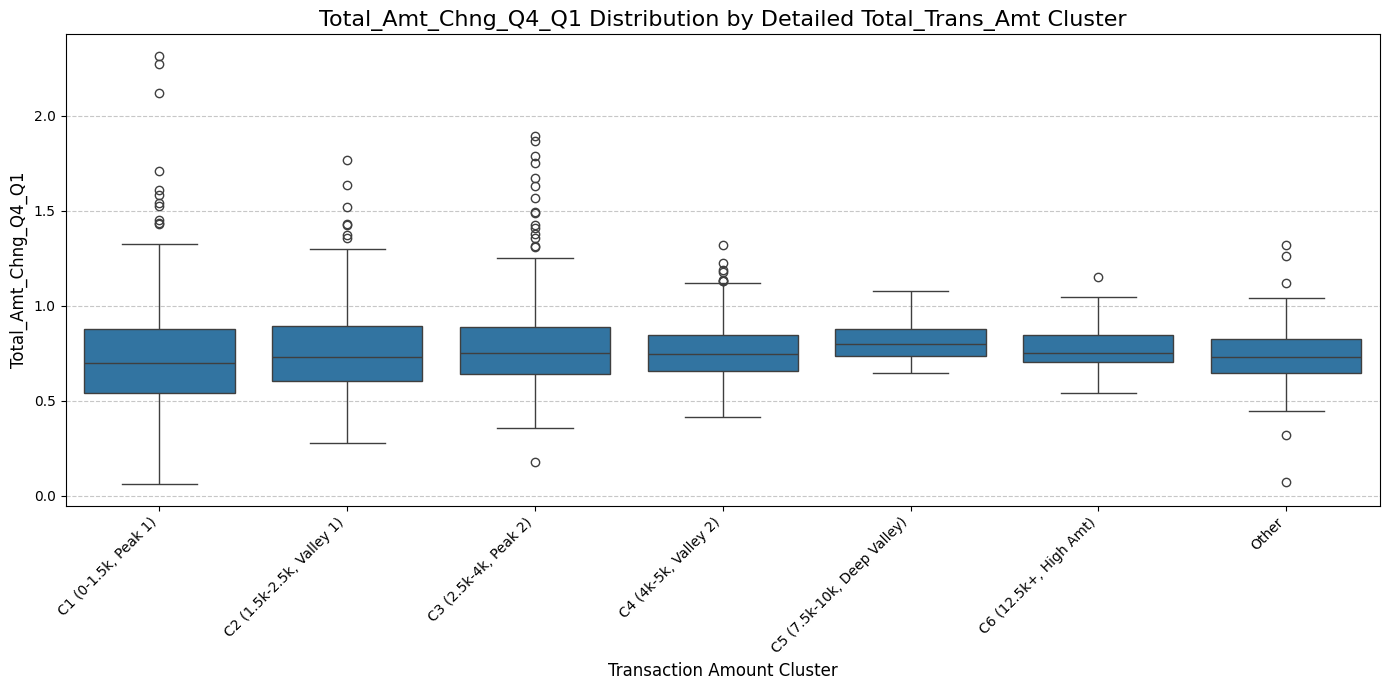


--- 各群組的 Total_Ct_Chng_Q4_Q1 統計描述 ---
                            count      mean       std    min      25%     50%  \
Amt_Cluster_Detailed                                                            
C1 (0-1.5k, Peak 1)         221.0  0.729190  0.455813  0.053  0.46200  0.6320   
C2 (1.5k-2.5k, Valley 1)    211.0  0.630033  0.258617  0.206  0.46300  0.5910   
C3 (2.5k-4k, Peak 2)        272.0  0.737824  0.210664  0.281  0.60375  0.7155   
C4 (4k-5k, Valley 2)        411.0  0.738200  0.155240  0.333  0.63600  0.7320   
C5 (7.5k-10k, Deep Valley)   86.0  0.713035  0.132412  0.508  0.61225  0.6950   
C6 (12.5k+, High Amt)       107.0  0.753682  0.098284  0.565  0.68800  0.7390   
Other                       112.0  0.731161  0.219105  0.293  0.59900  0.7200   

                                75%    max  
Amt_Cluster_Detailed                        
C1 (0-1.5k, Peak 1)         0.87500  3.714  
C2 (1.5k-2.5k, Valley 1)    0.76350  2.500  
C3 (2.5k-4k, Peak 2)        0.84250  2.000  
C4 (4k

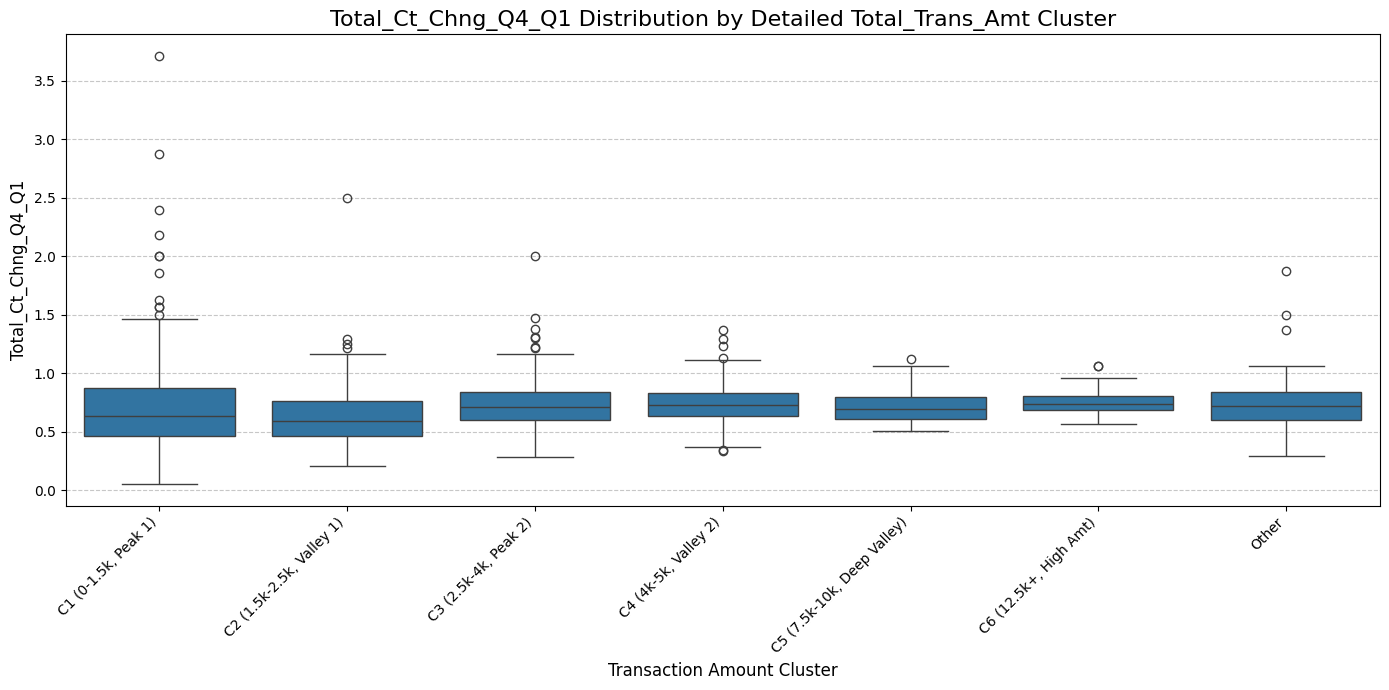

In [99]:

df_analysis = X_test_encoded.copy()

def assign_detailed_amt_cluster(amt):
    if 0 <= amt <= 1800:
        return "C1 (0-1.5k, Peak 1)"
    elif 1800 < amt <= 2500:
        return "C2 (1.5k-2.5k, Valley 1)"
    elif 2500 < amt <= 4000:
        return "C3 (2.5k-4k, Peak 2)"
    elif 4000 < amt <= 5000:
        return "C4 (4k-5k, Valley 2)"
    elif 7500 <= amt <= 10000:
        return "C5 (7.5k-10k, Deep Valley)"
    elif 12500 <= amt <= 17500:
        return "C6 (12.5k+, High Amt)"
    else:
        return "Other"

df_analysis['Amt_Cluster_Detailed'] = df_analysis['Total_Trans_Amt'].apply(assign_detailed_amt_cluster)

# 為了方便觀察，我們定義一個有序的列表
cluster_order = [
    "C1 (0-1.5k, Peak 1)",
    "C2 (1.5k-2.5k, Valley 1)",
    "C3 (2.5k-4k, Peak 2)",
    "C4 (4k-5k, Valley 2)",
    "C5 (7.5k-10k, Deep Valley)",
    "C6 (12.5k+, High Amt)",
    "Other"
]


# 查看每個群組有多少人
print("--- 各 Total_Trans_Amt 細分群組的客戶數量 ---")
print(df_analysis['Amt_Cluster_Detailed'].value_counts().reindex(cluster_order))
print("-" * 50)


# ---------------------------------------------------------------------------
# 2. 分析每個群組在其他關鍵特徵上的分佈
# ---------------------------------------------------------------------------
# 您可以將任何您感興趣的特徵加入這個列表
features_to_profile = [
    'Customer_Age',          # 客戶年齡
    'Total_Revolving_Bal',   # 總循環信用餘額
    'Total_Trans_Ct',        # 總交易次數
    'Months_on_book',        # 在帳月數 (客戶年資)
    'Credit_Limit',          # 信用額度
    'Months_Inactive_12_mon', # 近12個月未活動月份
    "Total_Relationship_Count",
    "Total_Amt_Chng_Q4_Q1",
    "Total_Ct_Chng_Q4_Q1",
]

for feature in features_to_profile:
    if feature in df_analysis.columns:
        print(f"\n--- 各群組的 {feature} 統計描述 ---")
        # 使用 groupby 和 describe 進行統計分析
        print(df_analysis.groupby('Amt_Cluster_Detailed')[feature].describe().reindex(cluster_order))

        # 繪製箱型圖進行視覺化比較
        plt.figure(figsize=(14, 7))
        sns.boxplot(x='Amt_Cluster_Detailed', y=feature, data=df_analysis, order=cluster_order)
        plt.title(f'{feature} Distribution by Detailed Total_Trans_Amt Cluster', fontsize=16)
        plt.xlabel('Transaction Amount Cluster', fontsize=12)
        plt.ylabel(feature, fontsize=12)
        plt.xticks(rotation=45, ha='right') # 將X軸標籤旋轉以防重疊
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout() # 自動調整佈局
        plt.show()
    else:
        print(f"警告：特徵 '{feature}' 不存在於 DataFrame 中。")

--- C1-C6 各群組客戶人數分佈 ---
                            Number of Customers
Amt_Cluster_Detailed                           
C1 (0-1.5k, Peak 1)                         227
C2 (1.5k-2.5k, Valley 1)                    215
C3 (2.5k-4k, Peak 2)                        289
C4 (4k-5k, Valley 2)                        425
C5 (7.5k-10k, Deep Valley)                   89
C6 (12.5k+, High Amt)                       111
Other                                       116
--------------------------------------------------


/var/folders/0y/cmyz7rnn4mn0841mr6yj1p680000gn/T/ipykernel_61137/1966887555.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=cluster_distribution.index, y=cluster_distribution.values, palette='viridis', order=cluster_order)


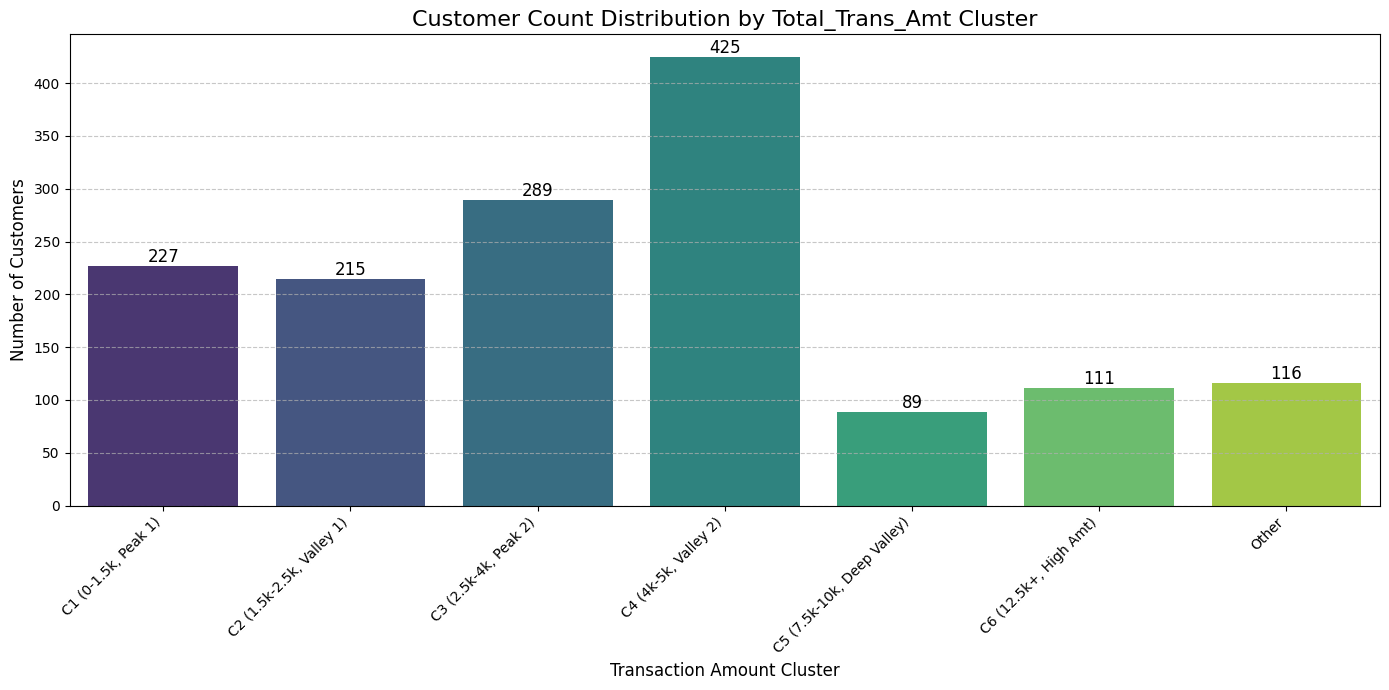

In [102]:
# 為了方便觀察和繪圖，我們定義一個有序的列表
cluster_order = [
    "C1 (0-1.5k, Peak 1)",
    "C2 (1.5k-2.5k, Valley 1)",
    "C3 (2.5k-4k, Peak 2)",
    "C4 (4k-5k, Valley 2)",
    "C5 (7.5k-10k, Deep Valley)",
    "C6 (12.5k+, High Amt)",
    "Other"
]

# ---------------------------------------------------------------------------
# 1. 計算每個群組的客戶人數
# ---------------------------------------------------------------------------
cluster_distribution = df_analysis['Amt_Cluster_Detailed'].value_counts().reindex(cluster_order).dropna()

print("--- C1-C6 各群組客戶人數分佈 ---")
# 將 Series 轉換為 DataFrame 以便更美觀地打印
print(cluster_distribution.to_frame(name='Number of Customers'))
print("-" * 50)


# ---------------------------------------------------------------------------
# 2. 視覺化人數分佈
# ---------------------------------------------------------------------------
plt.figure(figsize=(14, 7))
ax = sns.barplot(x=cluster_distribution.index, y=cluster_distribution.values, palette='viridis', order=cluster_order)

# 在長條圖上顯示具體數字
for index, count in enumerate(cluster_distribution):
    # 確保只在存在的長條上標註數字
    if pd.notna(count):
        plt.text(index, count, f'{int(count)}', ha='center', va='bottom', fontsize=12, color='black')

plt.title('Customer Count Distribution by Total_Trans_Amt Cluster', fontsize=16)
plt.xlabel('Transaction Amount Cluster', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

已成功將以下原始類別欄位加入分析數據中: ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


--- 各群組的 Income_Category 分佈比例 ---
Income_Category            $120K + $40K - $60K $60K - $80K $80K - $120K  \
Amt_Cluster_Detailed                                                      
C1 (0-1.5k, Peak 1)           8.6%       18.2%       15.5%        22.3%   
C2 (1.5k-2.5k, Valley 1)      8.0%       17.5%       15.1%        12.7%   
C3 (2.5k-4k, Peak 2)          5.7%       13.2%       19.6%        17.9%   
C4 (4k-5k, Valley 2)          5.0%       16.8%        7.9%         9.7%   
C5 (7.5k-10k, Deep Valley)    9.1%       22.7%       21.6%        21.6%   
C6 (12.5k+, High Amt)         9.1%       23.6%       17.3%        13.6%   
Other                         8.0%       16.8%       11.5%        15.0%   

Income_Category            Less than $40K Unknown  
Amt_Cluster_Detailed                               
C1 (0-1.5k, Peak 1)                 28.2%    7.3%  
C2 (1.5k-2.5k, Valley 1)   

/var/folders/0y/cmyz7rnn4mn0841mr6yj1p680000gn/T/ipykernel_61137/1067314185.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(distribution.reindex(cluster_order).applymap(lambda x: f"{x:.1%}" if pd.notna(x) else "0.0%"))


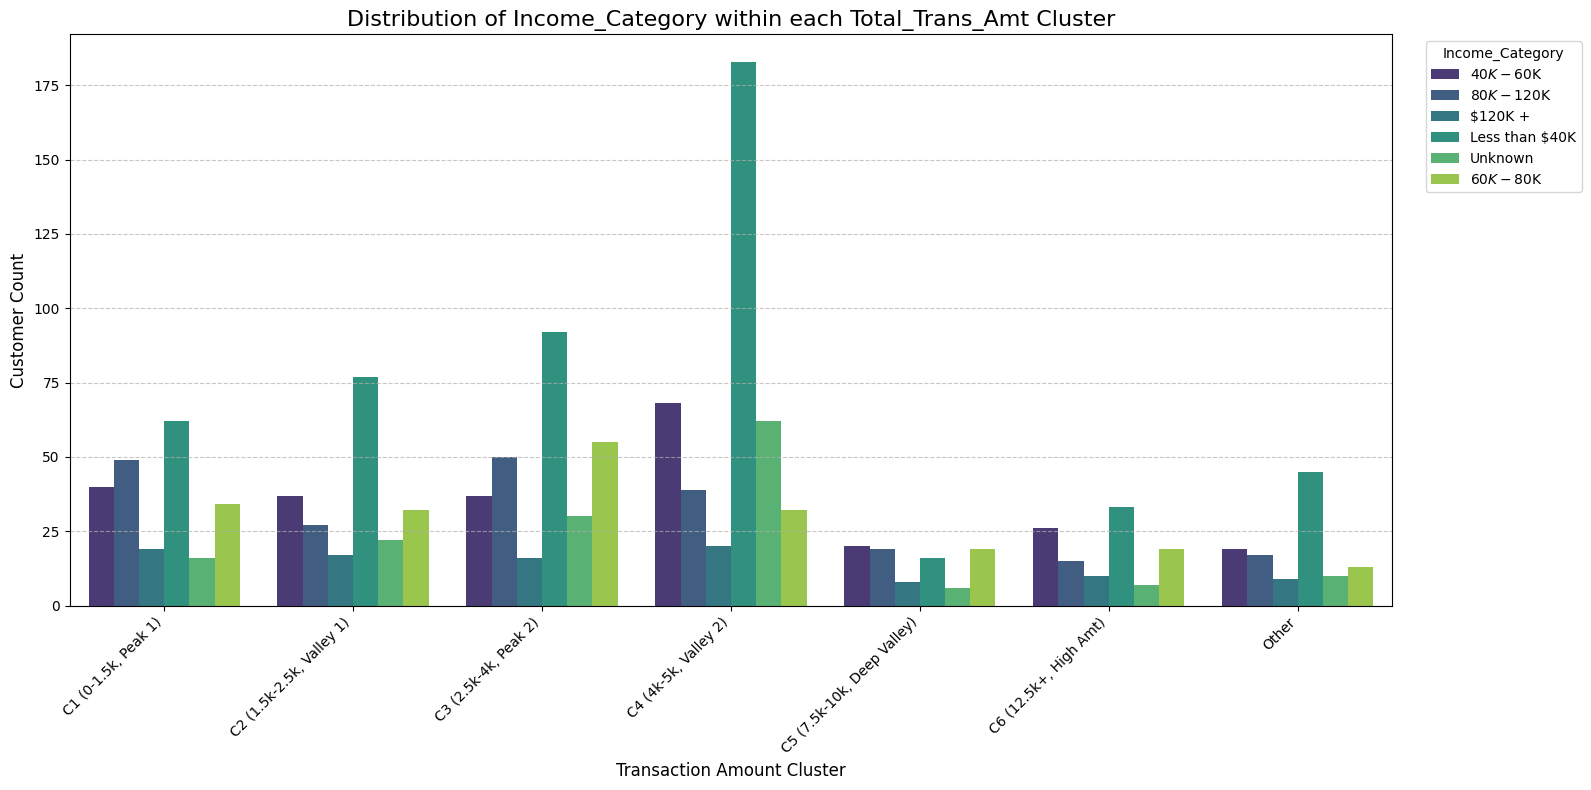


--- 各群組的 Education_Level 分佈比例 ---
Education_Level            College Doctorate Graduate High School  \
Amt_Cluster_Detailed                                                
C1 (0-1.5k, Peak 1)          11.4%      9.1%    26.4%       19.1%   
C2 (1.5k-2.5k, Valley 1)      9.4%      5.2%    32.5%       19.8%   
C3 (2.5k-4k, Peak 2)          9.7%      4.3%    31.0%       19.5%   
C4 (4k-5k, Valley 2)         10.5%      2.9%    28.6%       22.0%   
C5 (7.5k-10k, Deep Valley)    4.6%      5.7%    36.8%       19.5%   
C6 (12.5k+, High Amt)         7.3%      5.5%    34.5%       16.4%   
Other                         6.1%      5.2%    32.2%       22.6%   

Education_Level            Post-Graduate Uneducated Unknown  
Amt_Cluster_Detailed                                         
C1 (0-1.5k, Peak 1)                 6.4%      15.9%   11.8%  
C2 (1.5k-2.5k, Valley 1)            6.1%      11.3%   15.6%  
C3 (2.5k-4k, Peak 2)                4.3%      14.8%   16.2%  
C4 (4k-5k, Valley 2)             

/var/folders/0y/cmyz7rnn4mn0841mr6yj1p680000gn/T/ipykernel_61137/1067314185.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(distribution.reindex(cluster_order).applymap(lambda x: f"{x:.1%}" if pd.notna(x) else "0.0%"))


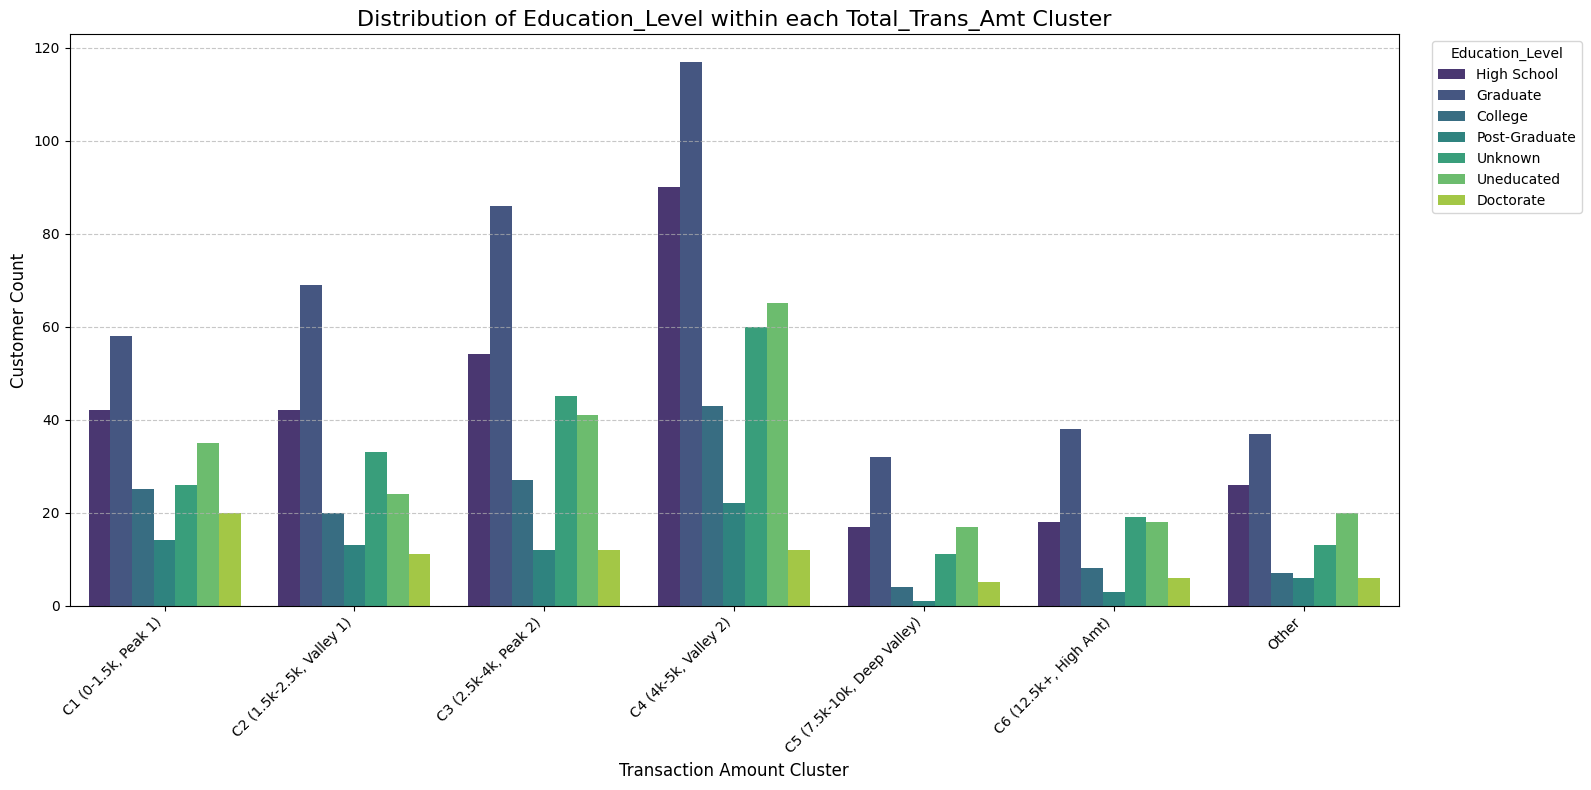


--- 各群組的 Marital_Status 分佈比例 ---
Marital_Status             Divorced Married Single Unknown
Amt_Cluster_Detailed                                      
C1 (0-1.5k, Peak 1)            8.3%   56.7%  29.5%    5.5%
C2 (1.5k-2.5k, Valley 1)       8.2%   52.2%  34.3%    5.3%
C3 (2.5k-4k, Peak 2)           9.3%   32.7%  52.0%    6.0%
C4 (4k-5k, Valley 2)           6.1%   46.0%  38.7%    9.2%
C5 (7.5k-10k, Deep Valley)     6.8%   38.6%  37.5%   17.0%
C6 (12.5k+, High Amt)         14.5%   37.3%  39.1%    9.1%
Other                          8.0%   46.0%  39.8%    6.2%
--------------------------------------------------


/var/folders/0y/cmyz7rnn4mn0841mr6yj1p680000gn/T/ipykernel_61137/1067314185.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(distribution.reindex(cluster_order).applymap(lambda x: f"{x:.1%}" if pd.notna(x) else "0.0%"))


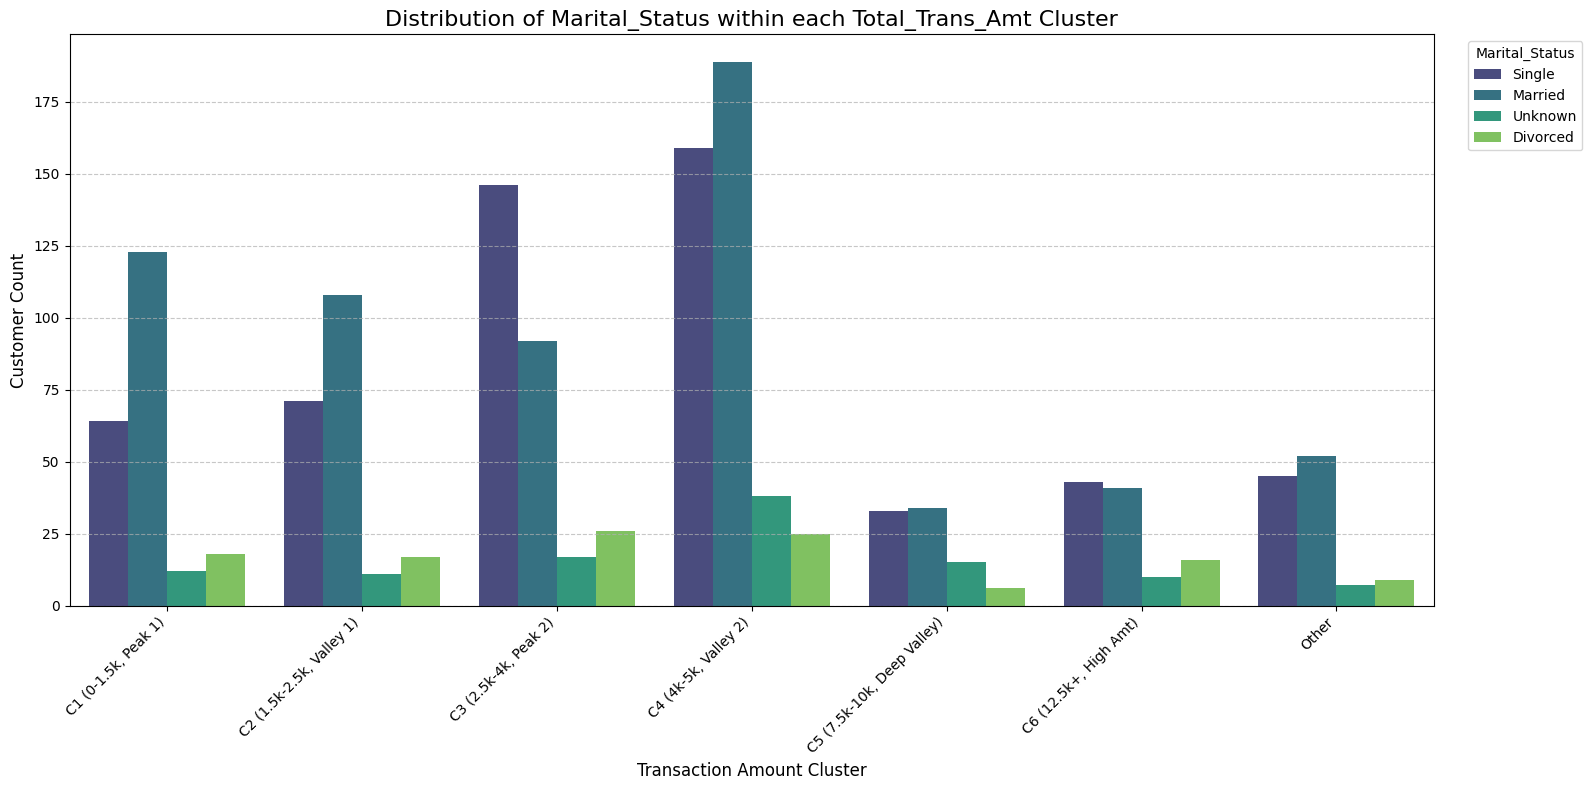


--- 各群組的 Gender 分佈比例 ---
Gender                          F      M
Amt_Cluster_Detailed                    
C1 (0-1.5k, Peak 1)         39.6%  60.4%
C2 (1.5k-2.5k, Valley 1)    52.4%  47.6%
C3 (2.5k-4k, Peak 2)        47.3%  52.7%
C4 (4k-5k, Valley 2)        72.5%  27.5%
C5 (7.5k-10k, Deep Valley)  34.1%  65.9%
C6 (12.5k+, High Amt)       45.5%  54.5%
Other                       60.2%  39.8%
--------------------------------------------------


/var/folders/0y/cmyz7rnn4mn0841mr6yj1p680000gn/T/ipykernel_61137/1067314185.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(distribution.reindex(cluster_order).applymap(lambda x: f"{x:.1%}" if pd.notna(x) else "0.0%"))


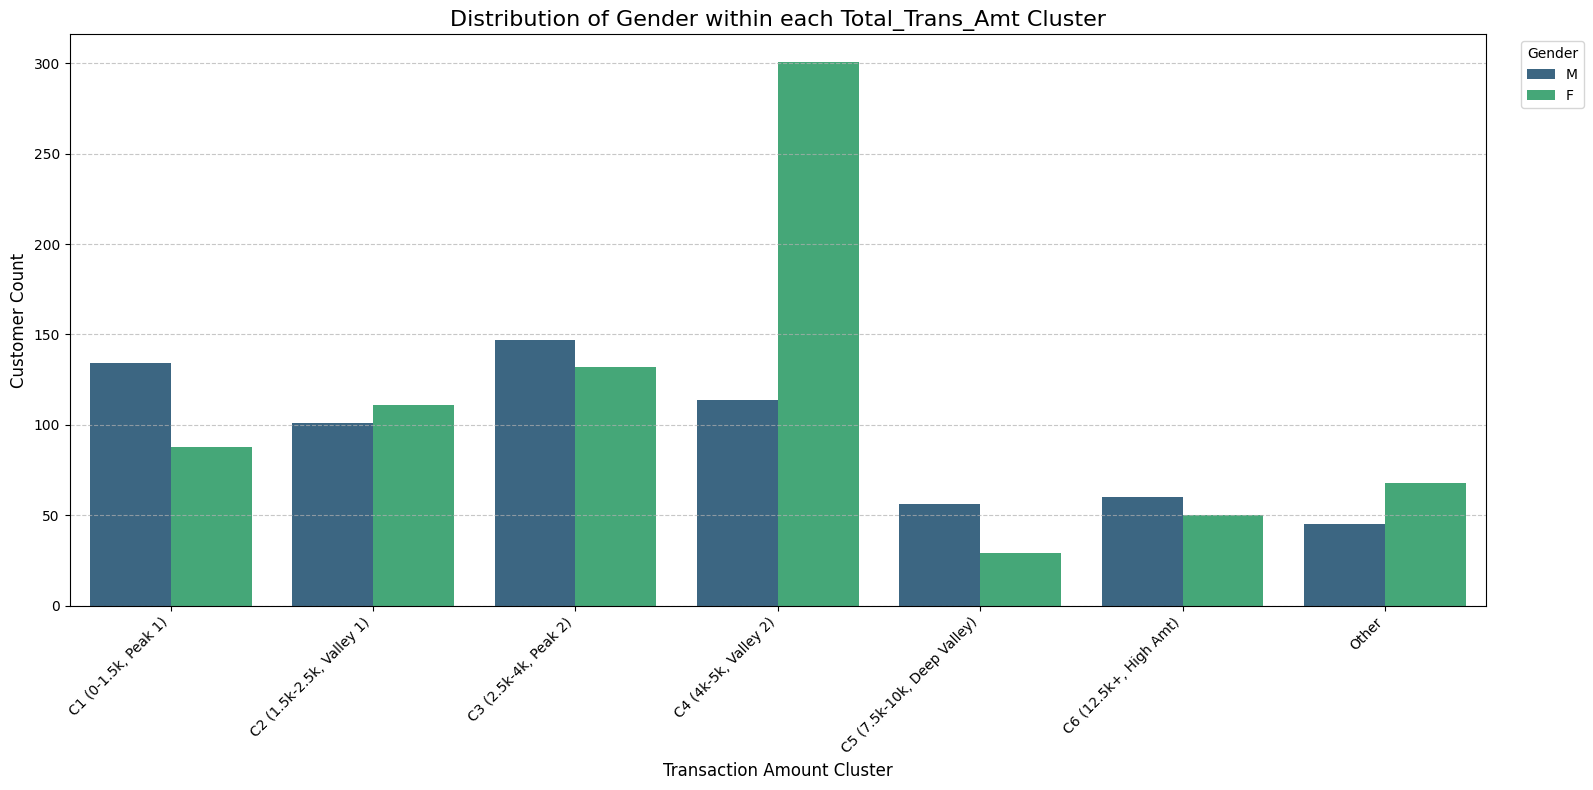

In [103]:
original_categorical_cols = df_test.select_dtypes(include='object').columns.tolist()
cols_to_add = [col for col in original_categorical_cols if col not in ['Attrition_Flag', 'CLIENTNUM']]

if df_analysis.index.equals(df_test.index):
    for col in cols_to_add:
        df_analysis[col] = df_test[col]
    print(f"已成功將以下原始類別欄位加入分析數據中: {cols_to_add}\n")
else:
    print("警告：df_analysis 和 df_test 的索引不匹配，無法直接加入欄位。請檢查您的數據處理流程。")

# ---------------------------------------------------------------------------
# 2. 分析與視覺化選定的類別特徵
# ---------------------------------------------------------------------------
# 我們選擇幾個重要的類別特徵進行分析
categorical_features_to_profile = [
    'Income_Category',   # 收入等級
    'Education_Level',   # 教育程度
    'Marital_Status',    # 婚姻狀況
    'Gender'             # 性別
]

# 沿用我們之前的群組排序
cluster_order = [
    "C1 (0-1.5k, Peak 1)", "C2 (1.5k-2.5k, Valley 1)", "C3 (2.5k-4k, Peak 2)",
    "C4 (4k-5k, Valley 2)", "C5 (7.5k-10k, Deep Valley)", "C6 (12.5k+, High Amt)", "Other"
]

for feature in categorical_features_to_profile:
    if feature in df_analysis.columns:
        # --- 頻次統計 (這部分不變，作為參考) ---
        print(f"\n--- 各群組的 {feature} 分佈比例 ---")
        distribution = df_analysis.groupby('Amt_Cluster_Detailed')[feature].value_counts(normalize=True).unstack(level=-1)
        print(distribution.reindex(cluster_order).applymap(lambda x: f"{x:.1%}" if pd.notna(x) else "0.0%"))
        print("-" * 50)
        
        # --- 視覺化 (修改版本) ---
        plt.figure(figsize=(16, 8))
        
        # 主要修改處：交換 x 和 hue 的參數
        sns.countplot(
            data=df_analysis, 
            x='Amt_Cluster_Detailed', # X 軸現在是我們的群組
            hue=feature,              # 用顏色區分不同的特徵類別 (例如：不同收入等級)
            order=cluster_order,      # 確保 X 軸按 C1, C2... 的順序排列
            palette='viridis'         # 您可以選擇喜歡的調色盤
        )
        
        plt.title(f'Distribution of {feature} within each Total_Trans_Amt Cluster', fontsize=16)
        plt.xlabel('Transaction Amount Cluster', fontsize=12) # X 軸標籤是群組
        plt.ylabel('Customer Count', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title=feature, bbox_to_anchor=(1.02, 1), loc='upper left') # 圖例的標題現在是特徵名稱
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print(f"警告：特徵 '{feature}' 不存在於 df_analysis 中。")

--- 各群組的客戶總數、流失數與流失率 (修正後) ---
                            total_customers  churned_customers  churn_rate
Amt_Cluster_Detailed                                                      
C1 (0-1.5k, Peak 1)                     227                 45    0.198238
C2 (1.5k-2.5k, Valley 1)                215                 90    0.418605
C3 (2.5k-4k, Peak 2)                    289                 51    0.176471
C4 (4k-5k, Valley 2)                    425                 10    0.023529
C5 (7.5k-10k, Deep Valley)               89                 30    0.337079
C6 (12.5k+, High Amt)                   111                  0    0.000000
Other                                   116                 11    0.094828
--------------------------------------------------


/var/folders/0y/cmyz7rnn4mn0841mr6yj1p680000gn/T/ipykernel_61137/2545474289.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_summary.index, y=cluster_summary['churn_rate'], palette='coolwarm')


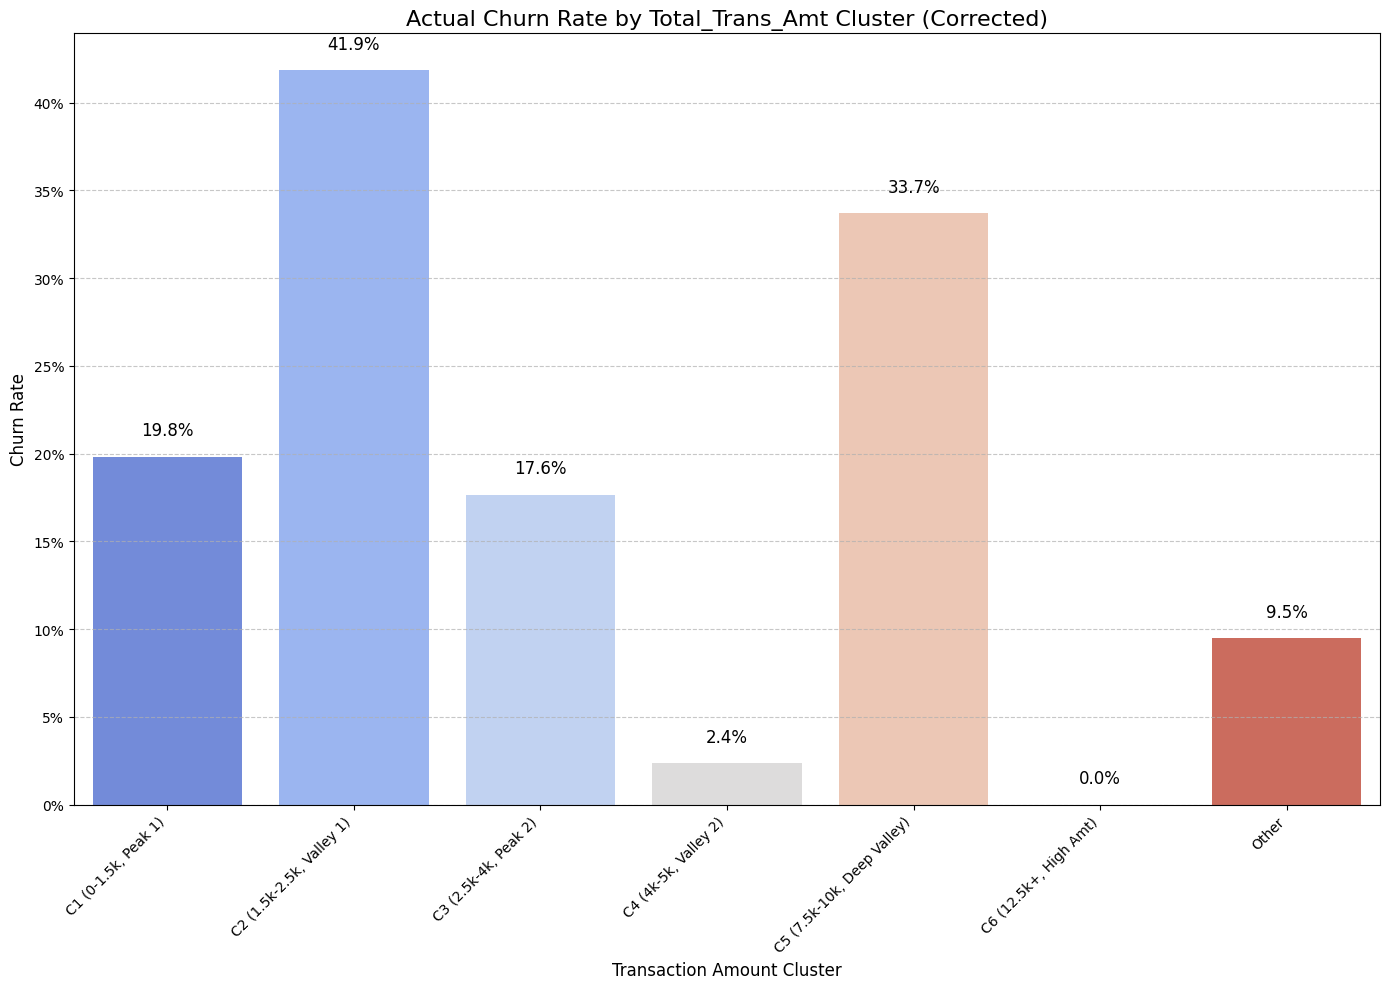

In [107]:
df_analysis['True_Label'] = Y_test_encoded
df_analysis['Predicted_Label'] = y_pred

# ---------------------------------------------------------------------------
# 1. & 2. 計算群組統計與流失率 (這部分不變)
# ---------------------------------------------------------------------------
cluster_summary = df_analysis.groupby('Amt_Cluster_Detailed').agg(
    total_customers=('True_Label', 'size'),
    churned_customers=('True_Label', lambda x: (x == 0).sum())
)
cluster_summary['churn_rate'] = cluster_summary['churned_customers'] / cluster_summary['total_customers']

# ---------------------------------------------------------------------------
# 修正後的 cluster_order 列表
# ---------------------------------------------------------------------------
# 根據您在步驟 2 提供的輸出，修正 C1 的名稱
cluster_order_corrected = [
    "C1 (0-1.5k, Peak 1)",      # 已從 1.8k 修正為 1.5k
    "C2 (1.5k-2.5k, Valley 1)",  # C2 的名稱看起來是正確的，但為保險起見，請核對
    "C3 (2.5k-4k, Peak 2)",
    "C4 (4k-5k, Valley 2)",
    "C5 (7.5k-10k, Deep Valley)",
    "C6 (12.5k+, High Amt)",
    "Other"
]
cluster_summary = cluster_summary.reindex(cluster_order_corrected).dropna() # dropna() 在這裡可以移除測試集中不存在的群組，更穩健

print("--- 各群組的客戶總數、流失數與流失率 (修正後) ---")
print(cluster_summary)
print("-" * 50)


# ---------------------------------------------------------------------------
# 3. 視覺化修正後的流失率
# ---------------------------------------------------------------------------
plt.figure(figsize=(14, 10))
sns.barplot(x=cluster_summary.index, y=cluster_summary['churn_rate'], palette='coolwarm')

# 在長條圖上顯示百分比數字
for index, value in enumerate(cluster_summary['churn_rate']):
    plt.text(index, value + 0.01, f'{value:.1%}', ha='center', va='bottom', fontsize=12, color='black')

plt.title('Actual Churn Rate by Total_Trans_Amt Cluster (Corrected)', fontsize=16)
plt.xlabel('Transaction Amount Cluster', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

測試集中總共有 237 位真實流失的客戶。

--- 在所有真實流失客戶中，各 Amt 群組的佔比分佈 (已排序) ---
Amt_Cluster_Detailed
C1 (0-1.5k, Peak 1)           18.99%
C2 (1.5k-2.5k, Valley 1)      37.97%
C3 (2.5k-4k, Peak 2)          21.52%
C4 (4k-5k, Valley 2)           4.22%
C5 (7.5k-10k, Deep Valley)    12.66%
Other                          4.64%
Name: proportion, dtype: object


/var/folders/0y/cmyz7rnn4mn0841mr6yj1p680000gn/T/ipykernel_61137/1684597917.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churner_distribution.index, y=churner_distribution.values, palette='viridis')


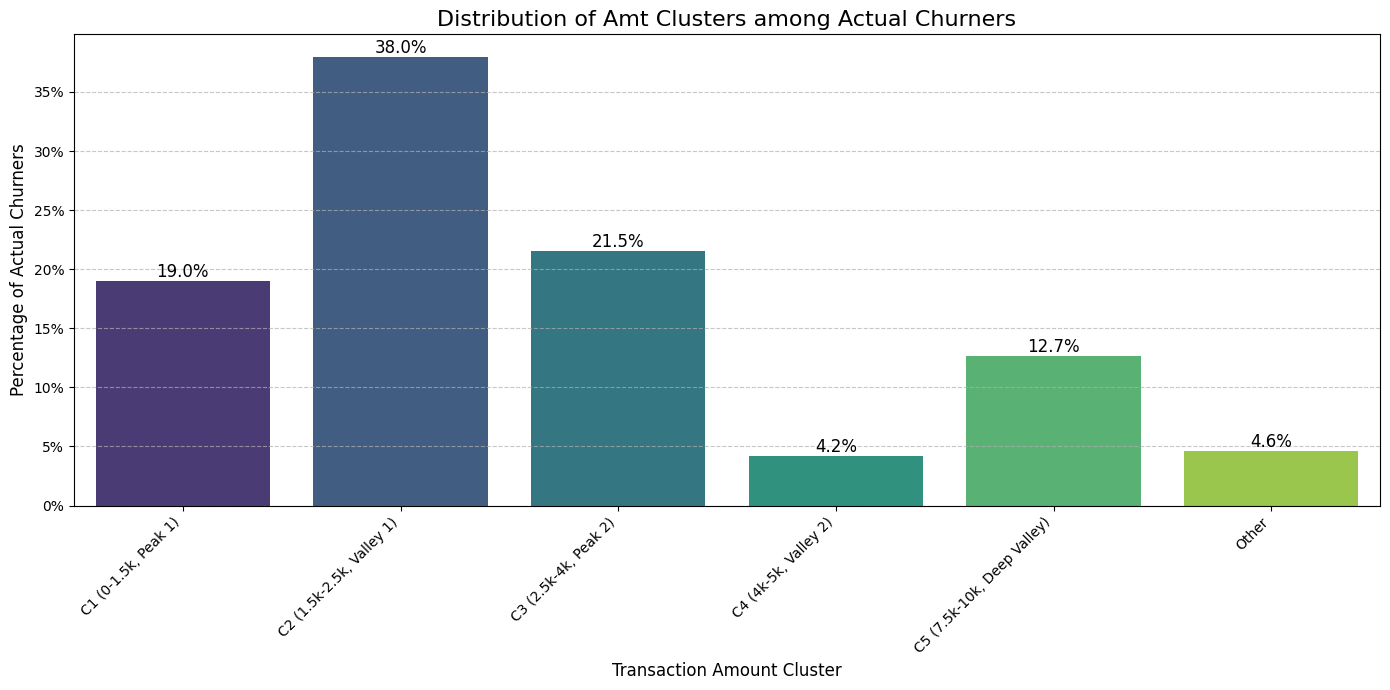


--- 深入分析 C5 群組中的 30 位真實流失客戶 ---
模型對 C5 群組中真實流失客戶的預測結果：
Predicted_Label
0    30
Name: count, dtype: int64

模型成功預測了所有 C5 群組中的流失客戶，沒有找到 FP 案例。


In [ ]:

# ====================================================================
actual_churners = df_analysis[df_analysis['True_Label'] == 0].copy()

if actual_churners.empty:
    print("測試集中沒有找到真實流失的客戶。")
else:
    print(f"測試集中總共有 {len(actual_churners)} 位真實流失的客戶。")
    
    # 1. 計算這些流失客戶中，來自各個群組的比例
    churner_distribution = actual_churners['Amt_Cluster_Detailed'].value_counts(normalize=True)
    
    # 2. 使用 reindex 確保輸出的順序是我們想要的 C1, C2... 邏輯順序
    churner_distribution = churner_distribution.reindex(cluster_order_corrected).dropna()
    
    print("\n--- 在所有真實流失客戶中，各 Amt 群組的佔比分佈 (已排序) ---")
    print(churner_distribution.apply(lambda x: f"{x:.2%}"))
    
    # 3. 視覺化 (使用 seaborn.barplot 以便更好地控制順序)
    plt.figure(figsize=(14, 7))
    sns.barplot(x=churner_distribution.index, y=churner_distribution.values, palette='viridis')

    # 在長條圖上顯示百分比數字
    for index, value in enumerate(churner_distribution):
        if pd.notna(value):
            plt.text(index, value, f'{value:.1%}', ha='center', va='bottom', fontsize=12)

    plt.title('Distribution of Amt Clusters among Actual Churners', fontsize=16)
    plt.xlabel('Transaction Amount Cluster', fontsize=12)
    plt.ylabel('Percentage of Actual Churners', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# ===========================================================================
# 步驟二：深入探討 C5 群組中的「真實流失客戶」(這部分邏輯原先就是正確的)
# ===========================================================================
c5_churners = actual_churners[actual_churners['Amt_Cluster_Detailed'] == "C5 (7.5k-10k, Deep Valley)"]

if c5_churners.empty:
    print("\n在 C5 群組中沒有找到真實流失的客戶。")
else:
    print(f"\n--- 深入分析 C5 群組中的 {len(c5_churners)} 位真實流失客戶 ---")
    
    # 查看模型對這群高風險客戶的預測表現
    c5_predictions = c5_churners['Predicted_Label'].value_counts()
    print("模型對 C5 群組中真實流失客戶的預測結果：")
    print(c5_predictions)
    
    # 尋找一個被錯誤預測為「留存」(Predicted_Label = 1) 的案例，即 FP 案例
    c5_fp_cases = c5_churners[c5_churners['Predicted_Label'] == 1]
    
    if c5_fp_cases.empty:
        print("\n模型成功預測了所有 C5 群組中的流失客戶，沒有找到 FP 案例。")
    else:
        # 選取第一個 FP 案例進行分析
        fp_case_in_c5_index = c5_fp_cases.index[0]
        
        print(f"\n--- 分析一個被『拉回去』的 C5 流失客戶案例 (索引: {fp_case_in_c5_index}) ---")
        print("這個客戶交易總額在 7.5k-10k 之間，且確實流失了，但模型預測他會留存。")
        
        # 繪製該案例的 Waterfall Plot
        label_map = {0: "Attrited", 1: "Existing"}
        shap_explanation_sample = shap.Explanation(
            values=shap_values[fp_case_in_c5_index,:],
            base_values=explainer.expected_value,
            data=X_test_encoded.iloc[fp_case_in_c5_index,:].values,
            feature_names=X_test_encoded.columns.tolist()
        )
        plt.figure(figsize=(10,8))
        shap.plots.waterfall(shap_explanation_sample, max_display=20, show=False)
        plt.title(f"Waterfall Plot for a C5 FP Case (Index: {fp_case_in_c5_index})\nTrue: {label_map[0]}, Predicted: {label_map[1]}", fontsize=12)
        plt.tight_layout()
        plt.show()